In [1]:
%matplotlib inline
import matplotlib

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import ScalarFormatter

import numpy as np
import pandas as pd

from pyspark.sql import functions as F
from pyspark.sql import types as T

import seaborn as sns

In [2]:
sns.set_style('ticks')
sns.set_context('paper')

matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['savefig.dpi'] = 600
matplotlib.rcParams['lines.markersize'] = 3
matplotlib.rcParams['lines.linewidth'] = 1

pd.options.display.width = 200


## Read author data file and parse it
Generate the following format:
```
    auid    pos    pmid    year    au_age_yr
```

In [21]:
def read_au_pmids(x):
    x = x.split("\t")
    auid = x[0]
    pmid_pos_gen = ((int(k[0]), int(k[1])) for k in (p.split("_") for p in x[1].split("|") if p != "-" or p != ""))
    return ((k[0], [auid, k[0], k[1]]) for k in pmid_pos_gen)

def read_pmid(x):
    x = x.split("\t")
    pmid = int(x[0])
    year = int(x[1])
    return (pmid, [year])

In [14]:
au_data = sc.textFile("data/Authors.nohead.txt")

In [15]:
au_data.take(1)

[u'9731334_2\t19497574_5|19452371_2|19308471_2|18784574_1|18329398_1|17923449_2|17632382_1|17202883_1|17156618_1|16990245_2|16329779_2|16329779_1|17230265_11|15187840_3|17096244_6|14630579_2|12596644_5|12427066_7|12398263_6|17458743_1|10671347_4|10386782_5|9731334_2']

In [22]:
list(read_au_pmids(au_data.take(1)[0]))

[(19497574, [u'9731334_2', 19497574, 5]),
 (19452371, [u'9731334_2', 19452371, 2]),
 (19308471, [u'9731334_2', 19308471, 2]),
 (18784574, [u'9731334_2', 18784574, 1]),
 (18329398, [u'9731334_2', 18329398, 1]),
 (17923449, [u'9731334_2', 17923449, 2]),
 (17632382, [u'9731334_2', 17632382, 1]),
 (17202883, [u'9731334_2', 17202883, 1]),
 (17156618, [u'9731334_2', 17156618, 1]),
 (16990245, [u'9731334_2', 16990245, 2]),
 (16329779, [u'9731334_2', 16329779, 2]),
 (16329779, [u'9731334_2', 16329779, 1]),
 (17230265, [u'9731334_2', 17230265, 11]),
 (15187840, [u'9731334_2', 15187840, 3]),
 (17096244, [u'9731334_2', 17096244, 6]),
 (14630579, [u'9731334_2', 14630579, 2]),
 (12596644, [u'9731334_2', 12596644, 5]),
 (12427066, [u'9731334_2', 12427066, 7]),
 (12398263, [u'9731334_2', 12398263, 6]),
 (17458743, [u'9731334_2', 17458743, 1]),
 (10671347, [u'9731334_2', 10671347, 4]),
 (10386782, [u'9731334_2', 10386782, 5]),
 (9731334, [u'9731334_2', 9731334, 2])]

In [24]:
pmid_data = sc.textFile("data/pmid_year_mesh.noheader.tsv").map(read_pmid)

In [25]:
pmid_data.take(5)

[(26151285, [2015]),
 (26151284, [2015]),
 (26151278, [2015]),
 (26151277, [2015]),
 (26151276, [2015])]

In [27]:
joined = au_data.flatMap(read_au_pmids).join(pmid_data).map(lambda x: tuple(x[1][0] + x[1][1]))

In [28]:
joined.map(lambda x: "\t".join("%s" for k in xrange(len(x))) % x).saveAsTextFile("out/auid_pmid_pos_yr")

### Compute author age in years and papers for each author
Store data in following format:
```
auid    first_yr    num_years    yr_span    num_papers    pmid    pos    year    age_yr    age_papers
```

In [31]:
t = pd.Series([1,2,3,4,4,3,2]).value_counts().sort_index()
(t.cumsum() - t).to_dict()

{1: 0, 2: 1, 3: 3, 4: 5}

In [65]:
def au_props(x):
    auid = x[0]
    pmid, pos, year = zip(*x[1])
    age_p = pd.Series(year).value_counts().sort_index()
    age_p = (age_p.cumsum() - age_p).to_dict()
    min_y = min(year) # First year
    cnt_p = len(pmid) # Number of papers
    num_y = len(age_p) # number of years published
    yr_span = max(year) - min_y
    return ((auid, min_y, num_y, yr_span, cnt_p,
             pmid[i], pos[i], year[i], year[i] - min_y, age_p[year[i]]) for i in xrange(len(pmid)))
    
    
def read_au_data(x):
    x = x.split("\t")
    auid = x[0]
    pmid, pos, year = [int(k) for k in x[1:]]
    return (auid, [[pmid, pos, year]])

In [57]:
joined_data = sc.textFile("out/auid_pmid_pos_yr").map(read_au_data)

In [58]:
joined_data.take(1)

[(u'3303400_5', [[1572866, 5, 1992]])]

In [59]:
list(au_props([u'3303400_5', [[1572866, 5, 1992],
                        [1572866, 5, 1993],
                        [1572866, 5, 1993],
                        [1572866, 5, 1994],]]))

(1572866, 1572866, 1572866, 1572866) (5, 5, 5, 5) (1992, 1993, 1993, 1994) {1992: 0, 1993: 1, 1994: 3}


[(u'3303400_5', 1992, 4, 1572866, 5, 1992, 0, 0),
 (u'3303400_5', 1992, 4, 1572866, 5, 1993, 1, 1),
 (u'3303400_5', 1992, 4, 1572866, 5, 1993, 1, 1),
 (u'3303400_5', 1992, 4, 1572866, 5, 1994, 2, 3)]

In [60]:
joined_data.reduceByKey(lambda x, y: x + y).take(1)

[(u'4217687_1',
  [[2676964, 2, 1989],
   [1158600, 1, 1975],
   [955795, 1, 1976],
   [7429716, 1, 1980],
   [738814, 1, 1978],
   [10580450, 1, 1999],
   [955801, 1, 1976],
   [9257163, 1, 1997],
   [10216826, 1, 1999],
   [4217687, 1, 1973],
   [7877900, 1, 1994]])]

In [66]:
list(au_props((u'4217687_1',
  [[2676964, 2, 1989],
   [1158600, 1, 1975],
   [955795, 1, 1976],
   [7429716, 1, 1980],
   [738814, 1, 1978],
   [10580450, 1, 1999],
   [955801, 1, 1976],
   [9257163, 1, 1997],
   [10216826, 1, 1999],
   [4217687, 1, 1973],
   [7877900, 1, 1994]])))

[(u'4217687_1', 1973, 9, 26, 11, 2676964, 2, 1989, 16, 6),
 (u'4217687_1', 1973, 9, 26, 11, 1158600, 1, 1975, 2, 1),
 (u'4217687_1', 1973, 9, 26, 11, 955795, 1, 1976, 3, 2),
 (u'4217687_1', 1973, 9, 26, 11, 7429716, 1, 1980, 7, 5),
 (u'4217687_1', 1973, 9, 26, 11, 738814, 1, 1978, 5, 4),
 (u'4217687_1', 1973, 9, 26, 11, 10580450, 1, 1999, 26, 9),
 (u'4217687_1', 1973, 9, 26, 11, 955801, 1, 1976, 3, 2),
 (u'4217687_1', 1973, 9, 26, 11, 9257163, 1, 1997, 24, 8),
 (u'4217687_1', 1973, 9, 26, 11, 10216826, 1, 1999, 26, 9),
 (u'4217687_1', 1973, 9, 26, 11, 4217687, 1, 1973, 0, 0),
 (u'4217687_1', 1973, 9, 26, 11, 7877900, 1, 1994, 21, 7)]

In [67]:
joined_data.reduceByKey(lambda x, y: x + y).flatMap(au_props)\
    .map(lambda x: "\t".join("%s" for k in xrange(len(x))) % x).saveAsTextFile("out/auid_pmid_pos_yr_age")

### Join author data with novelty data

In [78]:
def read_au_age(x):
    x = x.split("\t")
    pmid = int(x[5])
    return (pmid, x[:5] + x[6:])

def read_novelty(x):
    x = x.split("\t")
    pmid = int(x[0])
    return (pmid, x[1:])

In [79]:
author_data = sc.textFile("out/auid_pmid_pos_yr_age").map(read_au_age)
novelty_data = sc.textFile("out/pmid_novelty_all_scores_mesh_c/part-*").map(read_novelty)

print author_data.take(1)
print novelty_data.take(1)

[(8283980, [u'8283980_5', u'1993', u'1', u'0', u'1', u'5', u'1993', u'0', u'0'])]
[(23199753, [u'2013', u'87', u'35', u'1211.0', u'0.0', u'0.0', u'0.00282628', u'3.78484e-18', u'1', u'35', u'7.0', u'5', u'26'])]


In [81]:
joined_data = author_data.join(novelty_data).map(lambda x: tuple([x[0]] + x[1][0] + x[1][1]))\
    .map(lambda x: "\t".join("%s" for k in xrange(len(x))) % x).saveAsTextFile("out/pmid_author_age_novelty")

In [82]:
! head out/pmid_author_age_novelty/part-00000

15466496	11281312_6	2001	9	8	97	3	2004	3	29	2004	204	16	2759.0	0.0443904	0.0443904	0.0925864	2.9243e-40	1	0	1.0	23	117
15466496	11502628_1	2001	9	8	56	6	2004	3	9	2004	204	16	2759.0	0.0443904	0.0443904	0.0925864	2.9243e-40	1	0	1.0	23	117
15466496	2606593_1	1989	18	21	100	1	2004	15	47	2004	204	16	2759.0	0.0443904	0.0443904	0.0925864	2.9243e-40	1	0	1.0	23	117
15466496	3411064_2	1988	20	22	312	9	2004	16	96	2004	204	16	2759.0	0.0443904	0.0443904	0.0925864	2.9243e-40	1	0	1.0	23	117
15466496	1986053_1	1991	20	19	339	5	2004	13	88	2004	204	16	2759.0	0.0443904	0.0443904	0.0925864	2.9243e-40	1	0	1.0	23	117
15466496	6824092_3	1983	25	26	245	7	2004	21	145	2004	204	16	2759.0	0.0443904	0.0443904	0.0925864	2.9243e-40	1	0	1.0	23	117
15466496	8803861_1	1996	15	14	166	2	2004	8	65	2004	204	16	2759.0	0.0443904	0.0443904	0.0925864	2.9243e-40	1	0	1.0	23	117
15466496	11549553_2	2001	10	9	40	8	2004	3	5	2004	204	16	2759.0	0.0443904	0.0443904	0.0925864	2.9243e-40	1	0	1.0	23	117
15466496	4068816_2	1985	23	25	211	

## Generate author profiles

Data format of `out/pmid_author_age_novelty/part-00000`

```
pmid    auid    first_yr    num_years    yr_span    num_papers    pos    year    age_yr    age_papers    year    AbsValP    TFirstP    VolFirstP    acc_pos_vel_min    acc_pos_vel_max    acc_neg_vel_max    acc_neg_vel_min    Pair_AbsVal    Pair_TFirstP    Pair_VolFirstP    Mesh_counts    Exploded_Mesh_counts 
```

In [126]:
def clean_null(x):
    return float(x) if x != "\N" else None

def read_author_pmid(x):
    x = x.split("\t")
    pmid = int(x[0])
    auid = x[1]
    first_yr = int(x[2])
    num_papers = int(x[5])
    year = int(x[7])
    age_yr = int(x[8])
    TFirstP = clean_null(x[12])
    VolFirstP = clean_null(x[13])
    Pair_TFirstP = clean_null(x[19])
    Pair_VolFirstP = clean_null(x[20])
    return (auid, [first_yr, num_papers, year, age_yr,
                   TFirstP, VolFirstP, Pair_TFirstP, Pair_VolFirstP])

In [127]:
joined_data = sc.textFile("out/pmid_author_age_novelty").map(read_author_pmid).filter(
    lambda x: (x[1][0] > 1965) & (x[1][1] > 50) & (x[1][4] is not None) & (x[1][6] is not None)).map(
    lambda x: tuple([x[0], [x[1]]]))
joined_data.take(3)

[(u'6376809_2', [[1984, 244, 2004, 20, 33.0, 5781.0, 3.0, 3.0]]),
 (u'5585684_3', [[1967, 501, 1988, 21, 17.0, 663.0, 1.0, 2.0]]),
 (u'7458989_2', [[1980, 363, 1988, 8, 17.0, 663.0, 1.0, 2.0]])]

In [90]:
joined_data.count()

15528214

In [128]:
a = joined_data.reduceByKey(lambda x, y: x+y).take(3)

In [129]:
pd.DataFrame(a[0][1], columns=["first_yr", "num_papers", "year", "age_yr",
                   "TFirstP", "VolFirstP", "Pair_TFirstP", "Pair_VolFirstP"])

first_yr  num_papers  year  age_yr  TFirstP  VolFirstP  Pair_TFirstP  Pair_VolFirstP
0       1985          75  2002      17       37       4346             2               2
1       1985          75  2006      21       37       1232             0               1
2       1985          75  2000      15       37       3901            21              14
3       1985          75  2008      23       39       1321             0               1
4       1985          75  1987       2       37       7956             1               5
5       1985          75  1991       6       25       2099             0               1
6       1985          75  1998      13       25       1695             0               1
7       1985          75  1986       1       24       1231             0               1
8       1985          75  1998      13       34        306             4               3
9       1985          75  2007      22       39       1992             0               2
10      1985          75  1997      12       27       2667             0               1
11      1985          75  2005      20        6        147             0               1
12      1985          75  2009      24       48       1726             0               1
13      1985          75  1998      13       34        306            11               4
14      1985          75  2001      16       31       2964             3               3
15      1985          75  2007      22       42       5420             0               1
16      1985          75  1989       4       11        130             0               1
17      1985          75  1991       6       25        157             0               1
18      1985          75  2006      21       43        637             3               3
19      1985          75  2008      23       45        779            13               7
20      1985          75  2005      20       28        576             0               1
21      1985          75  2009      24       41       3477             3               7
22      1985          75  1992       7       26       1002            11               8
23      1985          75  2002      17       56        210            22               2
24      1985          75  1985       0        5        169             0               1
25      1985          75  1995      10        1         96             0               1
26      1985          75  2002      17       31       2002             0               1
27      1985          75  1993       8       30       3113             6              16
28      1985          75  2007      22       29       1196             0               1
29      1985          75  1992       7       13        868             0               1
..       ...         ...   ...     ...      ...        ...           ...             ...
45      1985          75  2008      23       45       5643            17              69
46      1985          75  2002      17       39       4346             5              17
47      1985          75  2002      17        9        162             8               9
48      1985          75  1996      11       33        100             0               1
49      1985          75  2004      19       38       3009             5              14
50      1985          75  2000      15       37       3901             8               4
51      1985          75  2001      16       22         78             0               1
52      1985          75  1995      10       32       8700            26              12
53      1985          75  2008      23       27        903             0               1
54      1985          75  1988       3       37        719            14               3
55      1985          75  2005      20        4         80             0               1
56      1985          75  1993       8       14        638             0               1
57      1985          75  1990       5       24        122             0               1

In [150]:
from statsmodels.api import OLS, RLM
from statsmodels.tools import add_constant

In [165]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
c_palette = sns.color_palette(flatui)

def gen_coeffs(x, plot=False, model=OLS):
    auid = x[0]
    first_yr = x[1][0][0]
    num_papers = x[1][0][1]
    df = pd.DataFrame(x[1], columns=["first_yr", "num_papers", "year", "age_yr",
                   "TFirstP", "VolFirstP", "Pair_TFirstP", "Pair_VolFirstP"])
    df = df.sort_values("age_yr")
    avg_coeffs = []
    min_coeffs = []
    cols = ["TFirstP", "VolFirstP", "Pair_TFirstP", "Pair_VolFirstP"]
    if plot:
        plt.close("all")
        plt.clf()
        fig, ax = plt.subplots(1,2)
        print "Avg per year models"
    for i,c in enumerate(cols):
        x = df["age_yr"]
        y = np.log10(df[c] + 1) if "TFirstP" in c else np.log10(df[c])
        X = add_constant(x)
        m = model(y,X)
        try:
            res = m.fit()
            if plot:
                ax[0].plot(x,y, color=c_palette[i], marker="o", linestyle="None", label=c)
                ax[0].plot(x,res.predict(X), color=c_palette[i], linestyle="--", label="%s fit" % c)
                print c, res.params["age_yr"], res.params["const"]
            avg_coeffs.extend([res.params["age_yr"], res.params["const"]])
        except:
            avg_coeffs.extend([None, None])
    if plot:
        ax[0].set_xlabel("Author Age (years)")
        ax[0].set_ylabel("y")
        print "Min per year models"
    # Fit min per year models
    df_min = df.groupby("age_yr").min().reset_index()
    for i,c in enumerate(cols):
        x = df_min["age_yr"]
        y = np.log10(df_min[c] + 1) if "TFirstP" in c else np.log10(df_min[c])
        X = add_constant(x)
        m = model(y,X)
        try:
            res = m.fit()
            if plot:
                ax[1].plot(x,y, color=c_palette[i], marker="o", linestyle="None", label=c)
                ax[1].plot(x,res.predict(X), color=c_palette[i], linestyle="--", label="%s fit" % c)
                print c, res.params["age_yr"], res.params["const"]
            min_coeffs.extend([res.params["age_yr"], res.params["const"]])
        except:
            min_coeffs.extend([None, None])
    if plot:
        ax[1].set_xlabel("Author Age (years)")
        ax[1].set_ylabel("y (min per year)")

        lgd = fig.legend(*ax[0].get_legend_handles_labels(),
        loc = 'upper center',bbox_to_anchor=(0.5, 1.2),
        title = "Type of Novelty Score",
        ncol=4, frameon=True, fancybox=True)
        fig.tight_layout()
    t = df_min.set_index("age_yr").idxmin()
    return tuple([auid, first_yr, num_papers] + t[cols].tolist() + avg_coeffs + min_coeffs)

In [164]:
gen_coeffs(a[0])

(u'2984874_4',
 1985,
 75,
 10,
 16,
 0,
 0,
 0.014490996106815885,
 1.1962047005028416,
 0.02649785792899232,
 2.5969031014070332,
 0.010087864237485061,
 0.20837753188711791,
 0.011180076836336289,
 0.15222492369168433,
 0.0059540306861122268,
 1.117853182762431,
 0.0054956885236488867,
 2.5045063675340149,
 -0.0057937200343001543,
 0.17927714736430564,
 -0.0035787760599497957,
 0.14115623798736515)

Avg per year models
TFirstP 0.0144909961068 1.1962047005
VolFirstP 0.026497857929 2.59690310141
Pair_TFirstP 0.0100878642375 0.208377531887
Pair_VolFirstP 0.0111800768363 0.152224923692
Min per year models
TFirstP 0.00595403068611 1.11785318276
VolFirstP 0.00549568852365 2.50450636753
Pair_TFirstP -0.0057937200343 0.179277147364
Pair_VolFirstP -0.00357877605995 0.141156237987


(u'2984874_4',
 1985,
 75,
 0.014490996106815885,
 1.1962047005028416,
 0.02649785792899232,
 2.5969031014070332,
 0.010087864237485061,
 0.20837753188711791,
 0.011180076836336289,
 0.15222492369168433,
 0.0059540306861122268,
 1.117853182762431,
 0.0054956885236488867,
 2.5045063675340149,
 -0.0057937200343001543,
 0.17927714736430564,
 -0.0035787760599497957,
 0.14115623798736515)

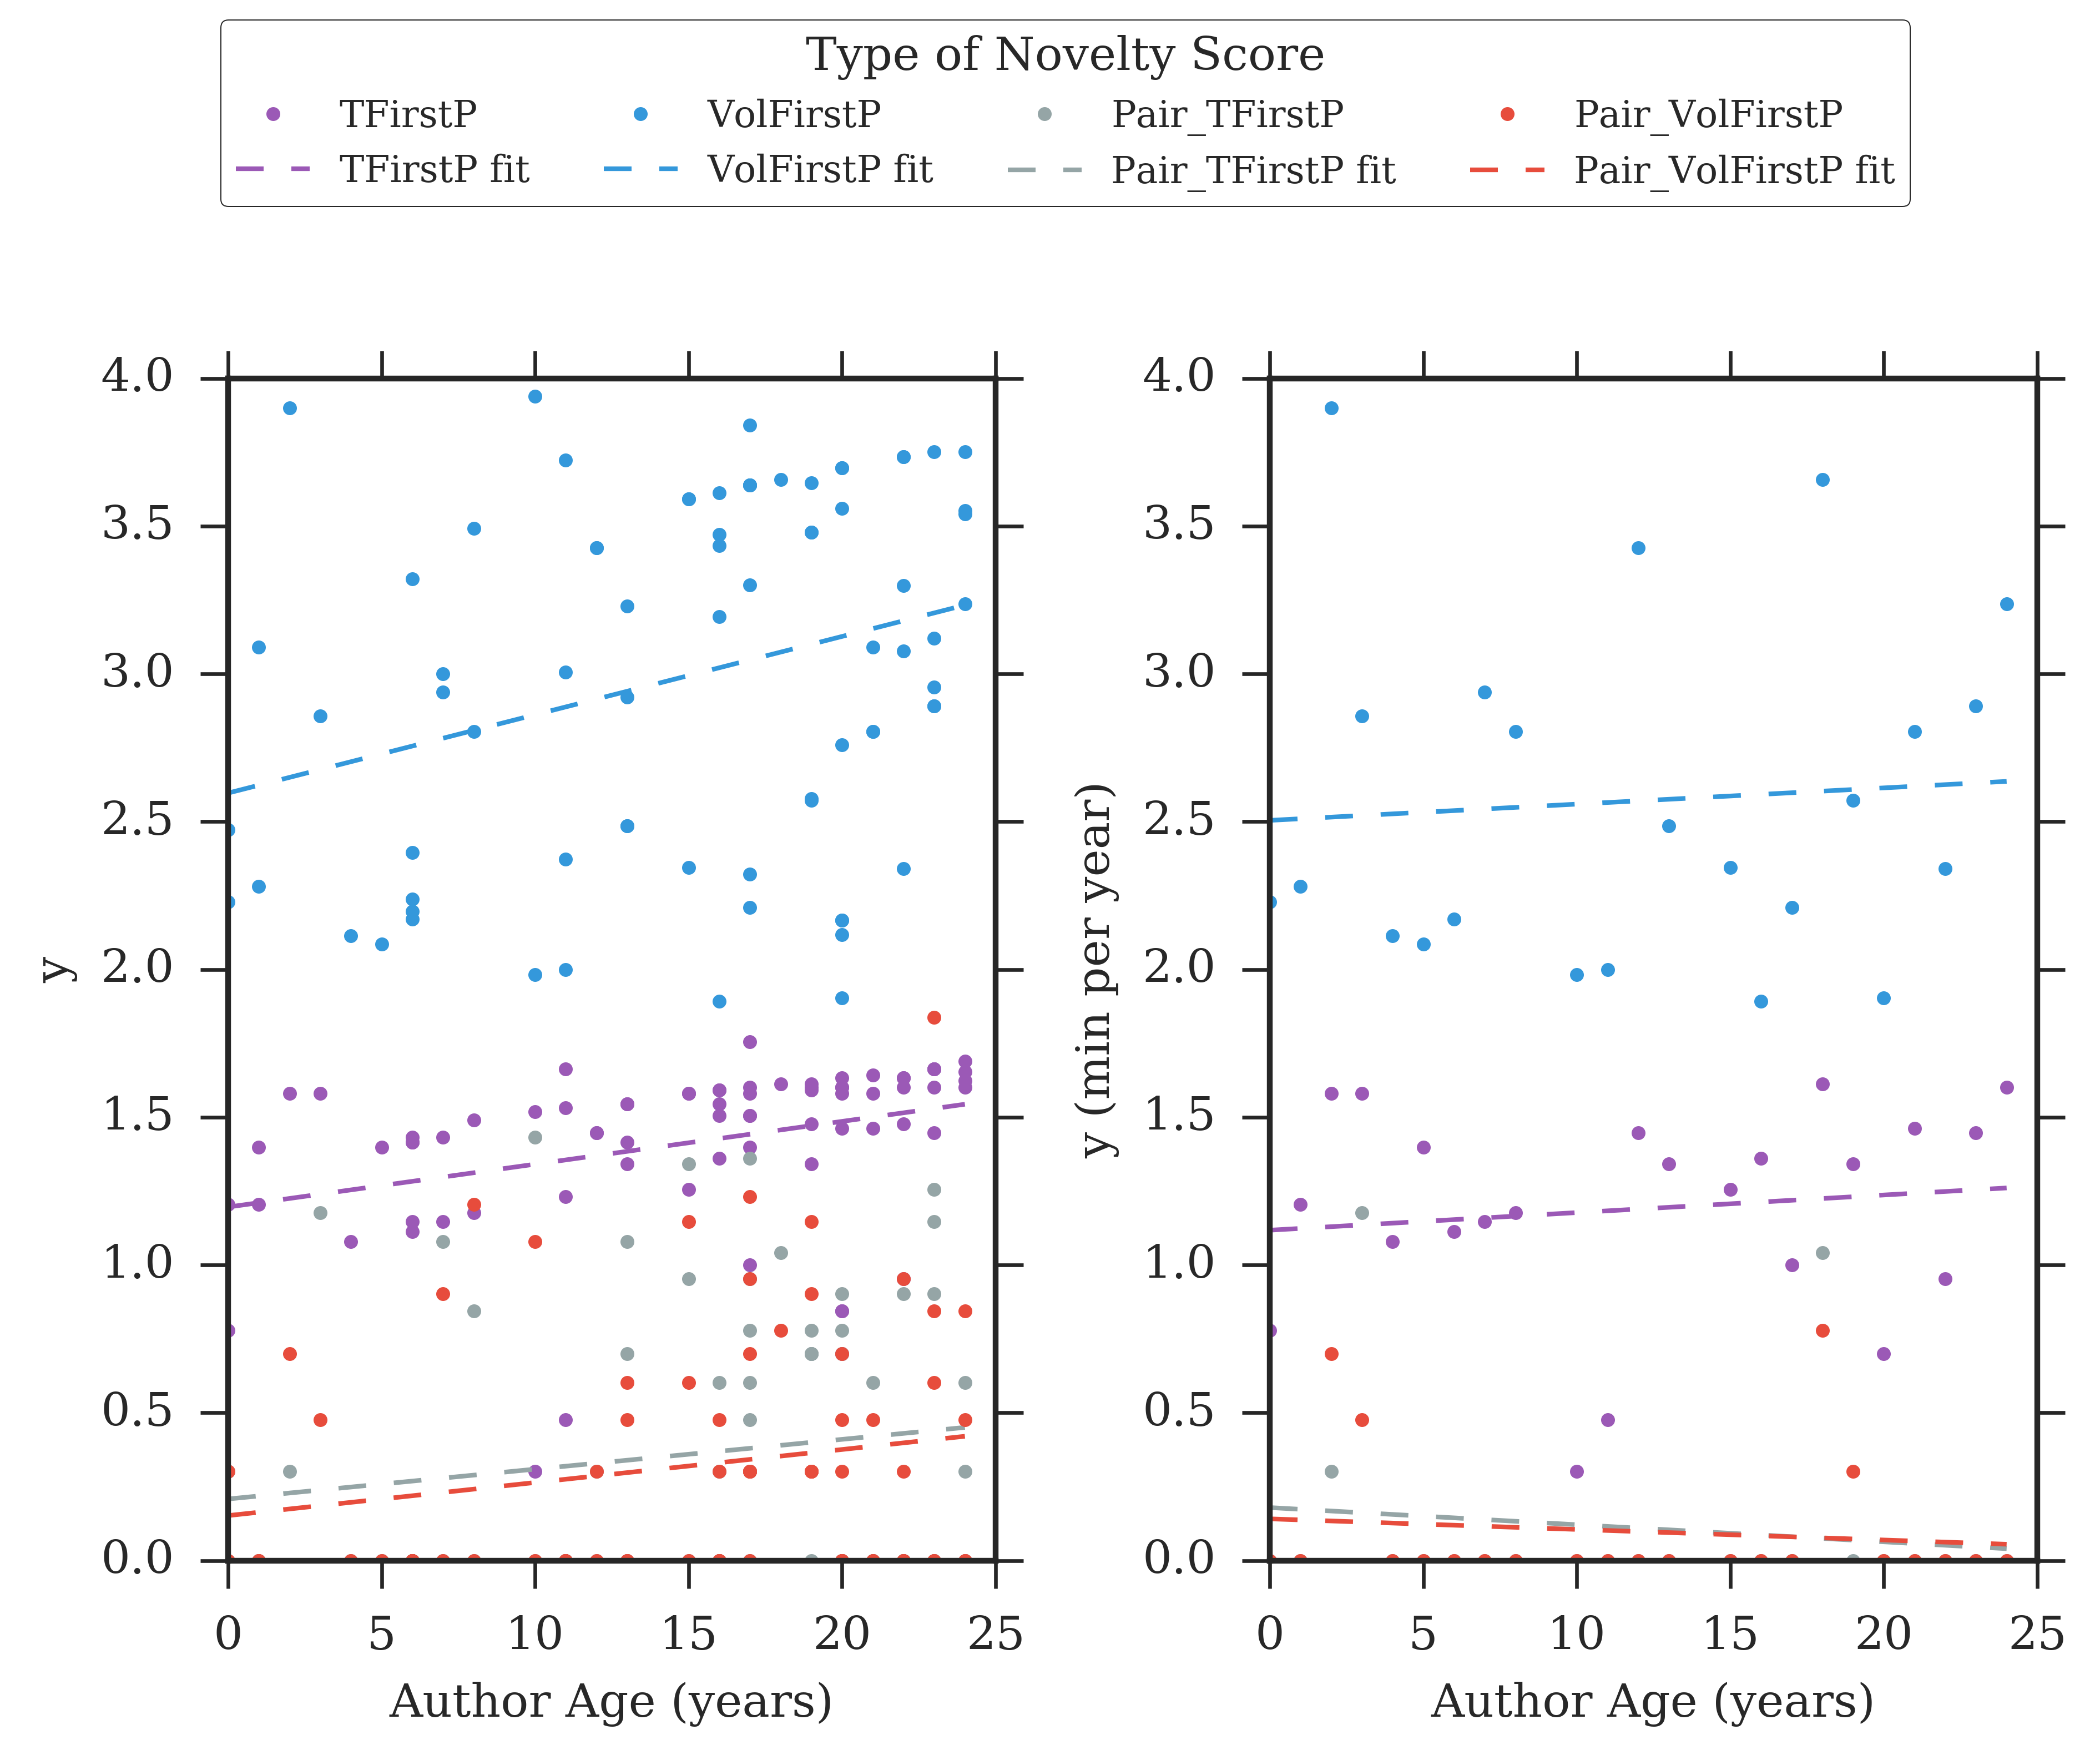

In [153]:
gen_coeffs(a[0], plot=True)

Avg per year models
TFirstP 0.0154951961586 1.23445891251
VolFirstP 0.0278062059312 2.57754376275
Pair_TFirstP 0.0114993360015 0.164394997716
Pair_VolFirstP 0.00990612185092 0.133129617021
Min per year models
TFirstP 0.00593136887637 1.16263616929
VolFirstP 0.00988410018195 2.39034415703
Pair_TFirstP -3.58241007264e-25 8.32257916212e-24
Pair_VolFirstP -7.12381968254e-20 2.92477948938e-18


(u'2984874_4',
 1985,
 75,
 0.015495196158572137,
 1.2344589125090848,
 0.027806205931194913,
 2.5775437627466355,
 0.011499336001492579,
 0.16439499771607269,
 0.0099061218509203085,
 0.13312961702116685,
 0.0059313688763660277,
 1.1626361692873193,
 0.0098841001819517348,
 2.3903441570287174,
 -3.5824100726360089e-25,
 8.3225791621239219e-24,
 -7.1238196825433458e-20,
 2.9247794893822323e-18)

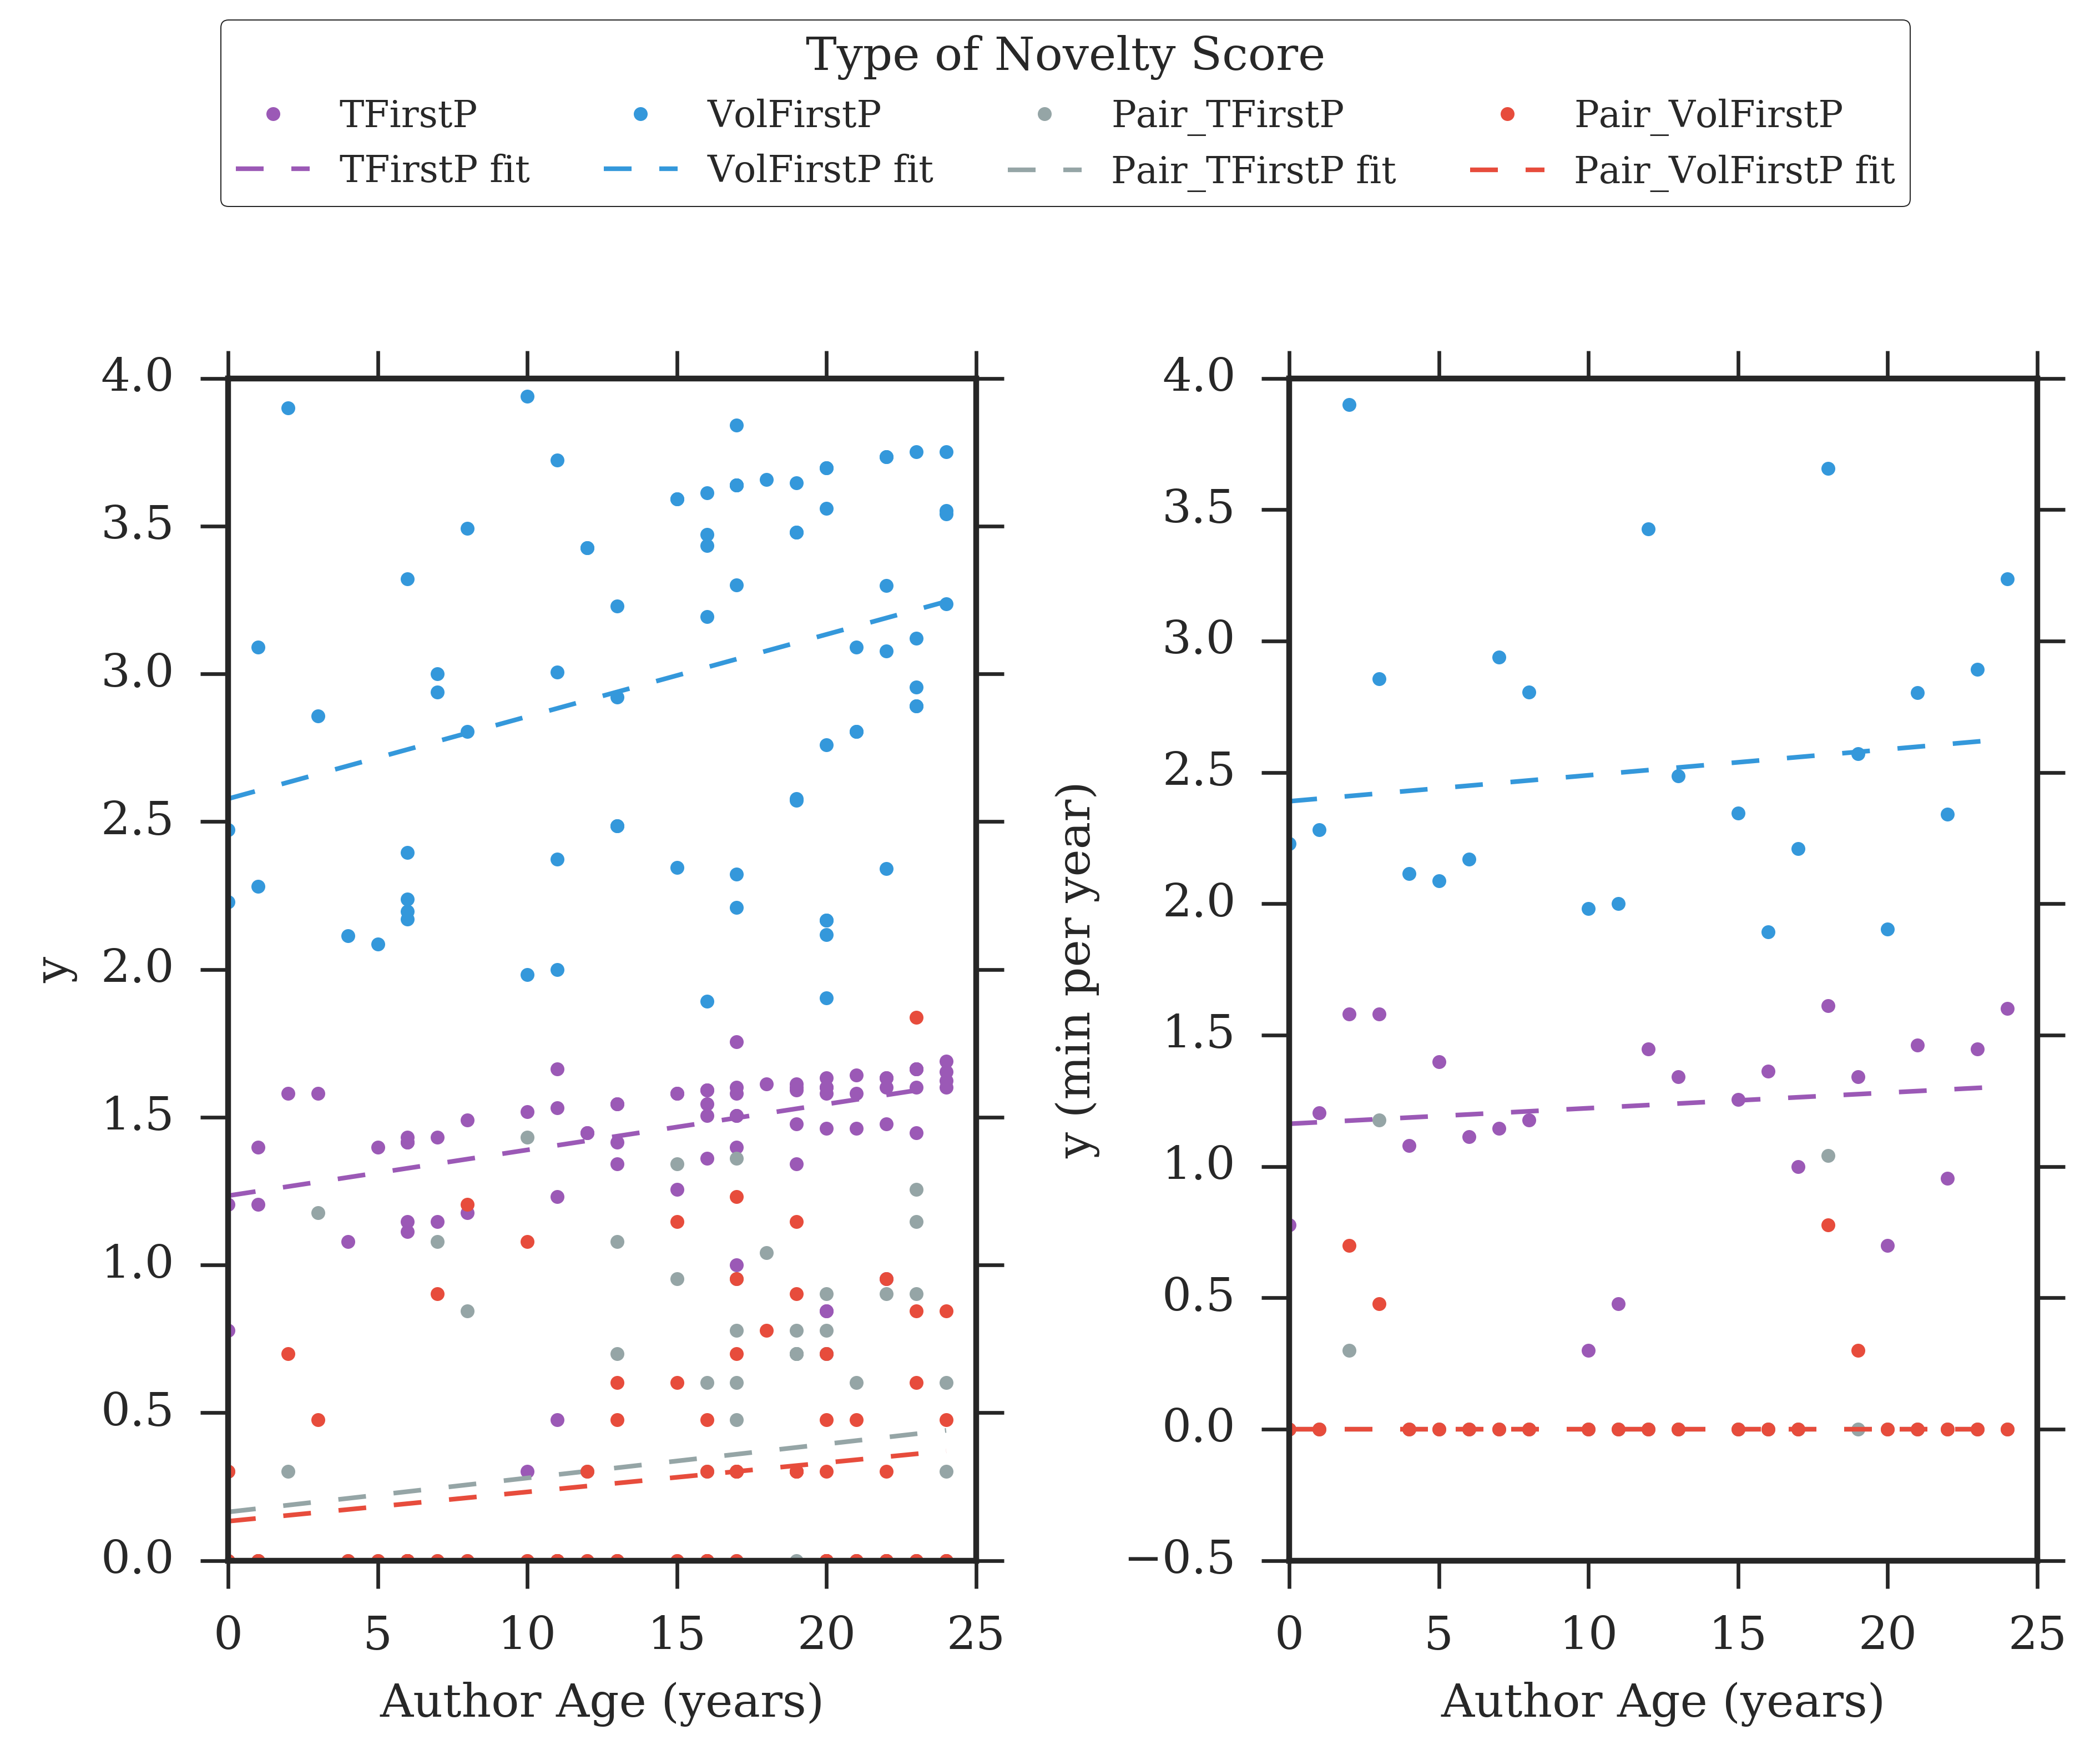

In [154]:
gen_coeffs(a[0], plot=True, model=RLM)

Avg per year models
TFirstP 0.00599694041312 1.25102249184
VolFirstP 0.0136107309881 3.05841283562
Pair_TFirstP -0.000954665057863 0.321898376897
Pair_VolFirstP -0.00116658697733 0.393399242547
Min per year models
TFirstP 0.0141278391026 0.924982482852
VolFirstP 0.021591429576 2.49406950585
Pair_TFirstP 2.35235162607e-28 -1.58927829967e-27
Pair_VolFirstP 1.18381813909e-23 -3.15939832921e-23


(u'4266490_1',
 1972,
 168,
 0.0059969404131198587,
 1.2510224918439721,
 0.013610730988125012,
 3.0584128356242228,
 -0.00095466505786340216,
 0.32189837689695522,
 -0.0011665869773325576,
 0.39339924254712344,
 0.014127839102649656,
 0.9249824828520028,
 0.021591429576019575,
 2.4940695058541591,
 2.3523516260670971e-28,
 -1.5892782996710672e-27,
 1.1838181390930708e-23,
 -3.1593983292112362e-23)

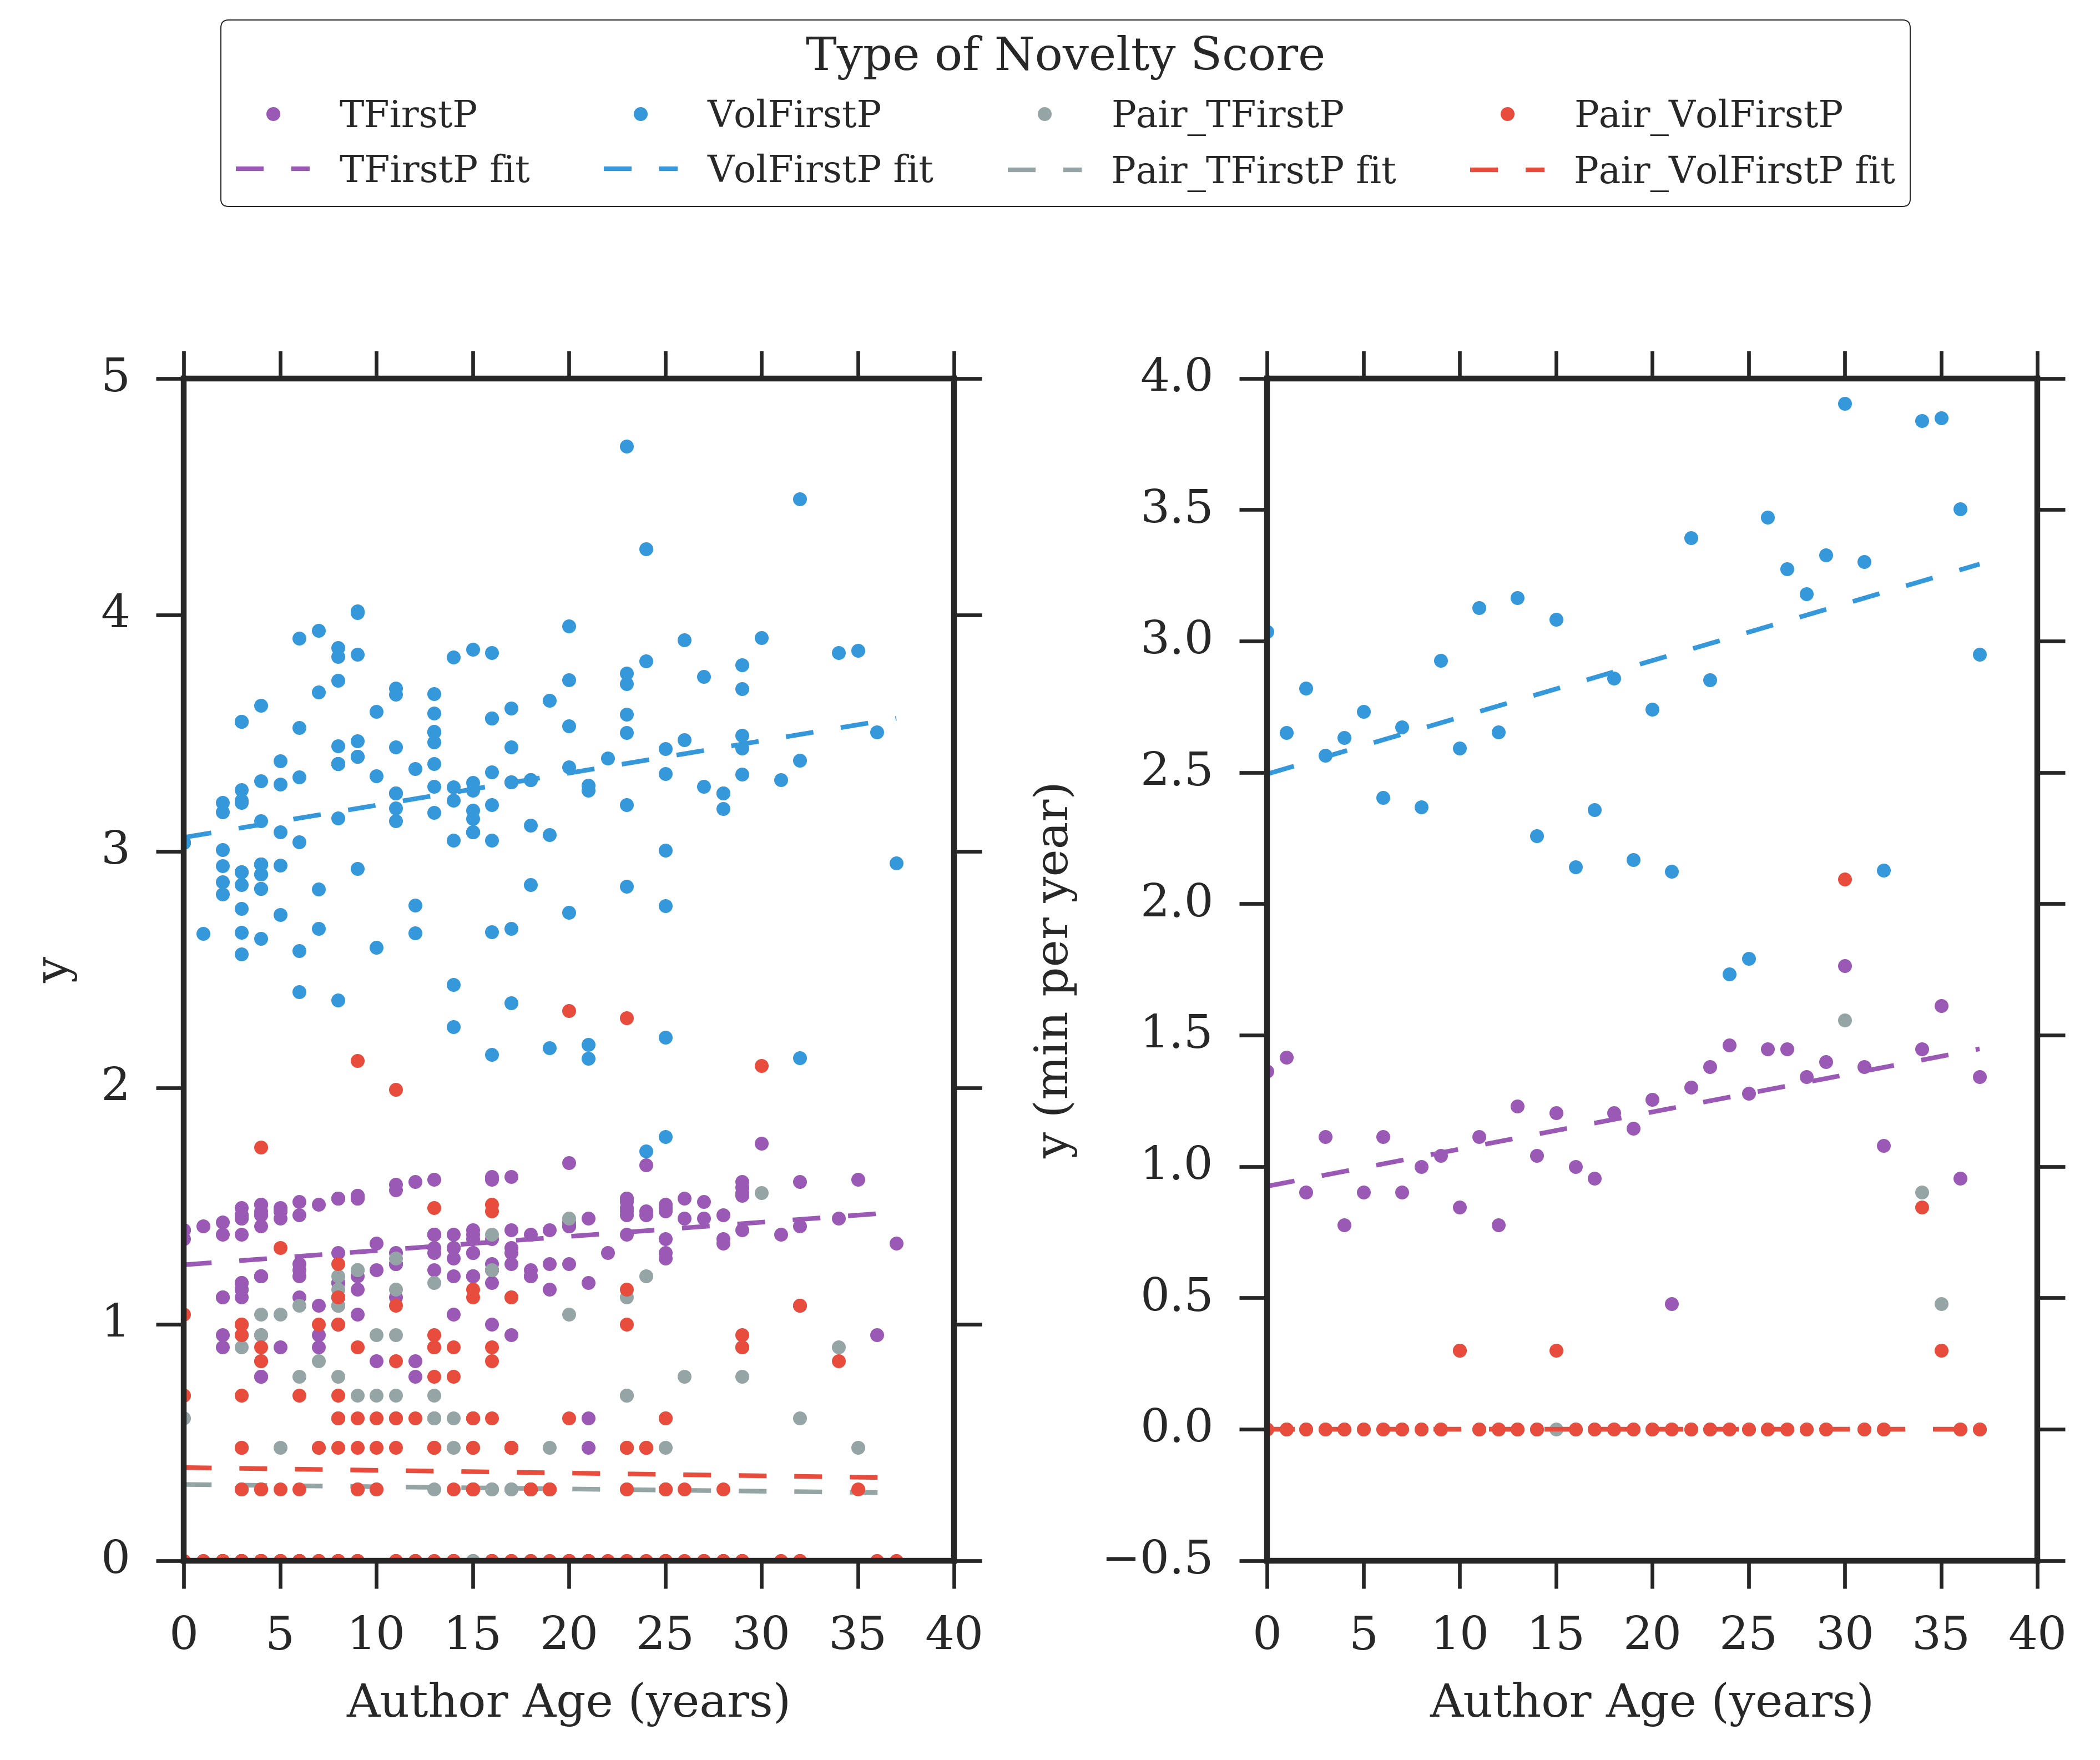

In [155]:
gen_coeffs(a[1], plot=True, model=RLM)

Avg per year models
TFirstP 0.00579894433289 1.23424208603
VolFirstP 0.00966591342676 3.08166307712
Pair_TFirstP -0.000359346796049 0.344816394587
Pair_VolFirstP 0.000193671195581 0.417796481654
Min per year models
TFirstP 0.0114735026637 0.965748450486
VolFirstP 0.0186860404549 2.48780730699
Pair_TFirstP 0.00883824262295 -0.07254267079
Pair_VolFirstP 0.00919556181379 -0.0626869379209


(u'4266490_1',
 1972,
 168,
 0.0057989443328889025,
 1.2342420860277084,
 0.0096659134267612461,
 3.0816630771195435,
 -0.00035934679604936041,
 0.34481639458721264,
 0.00019367119558122957,
 0.41779648165449579,
 0.011473502663726069,
 0.96574845048563907,
 0.018686040454919561,
 2.4878073069925661,
 0.008838242622946477,
 -0.072542670790034236,
 0.0091955618137917524,
 -0.062686937920865937)

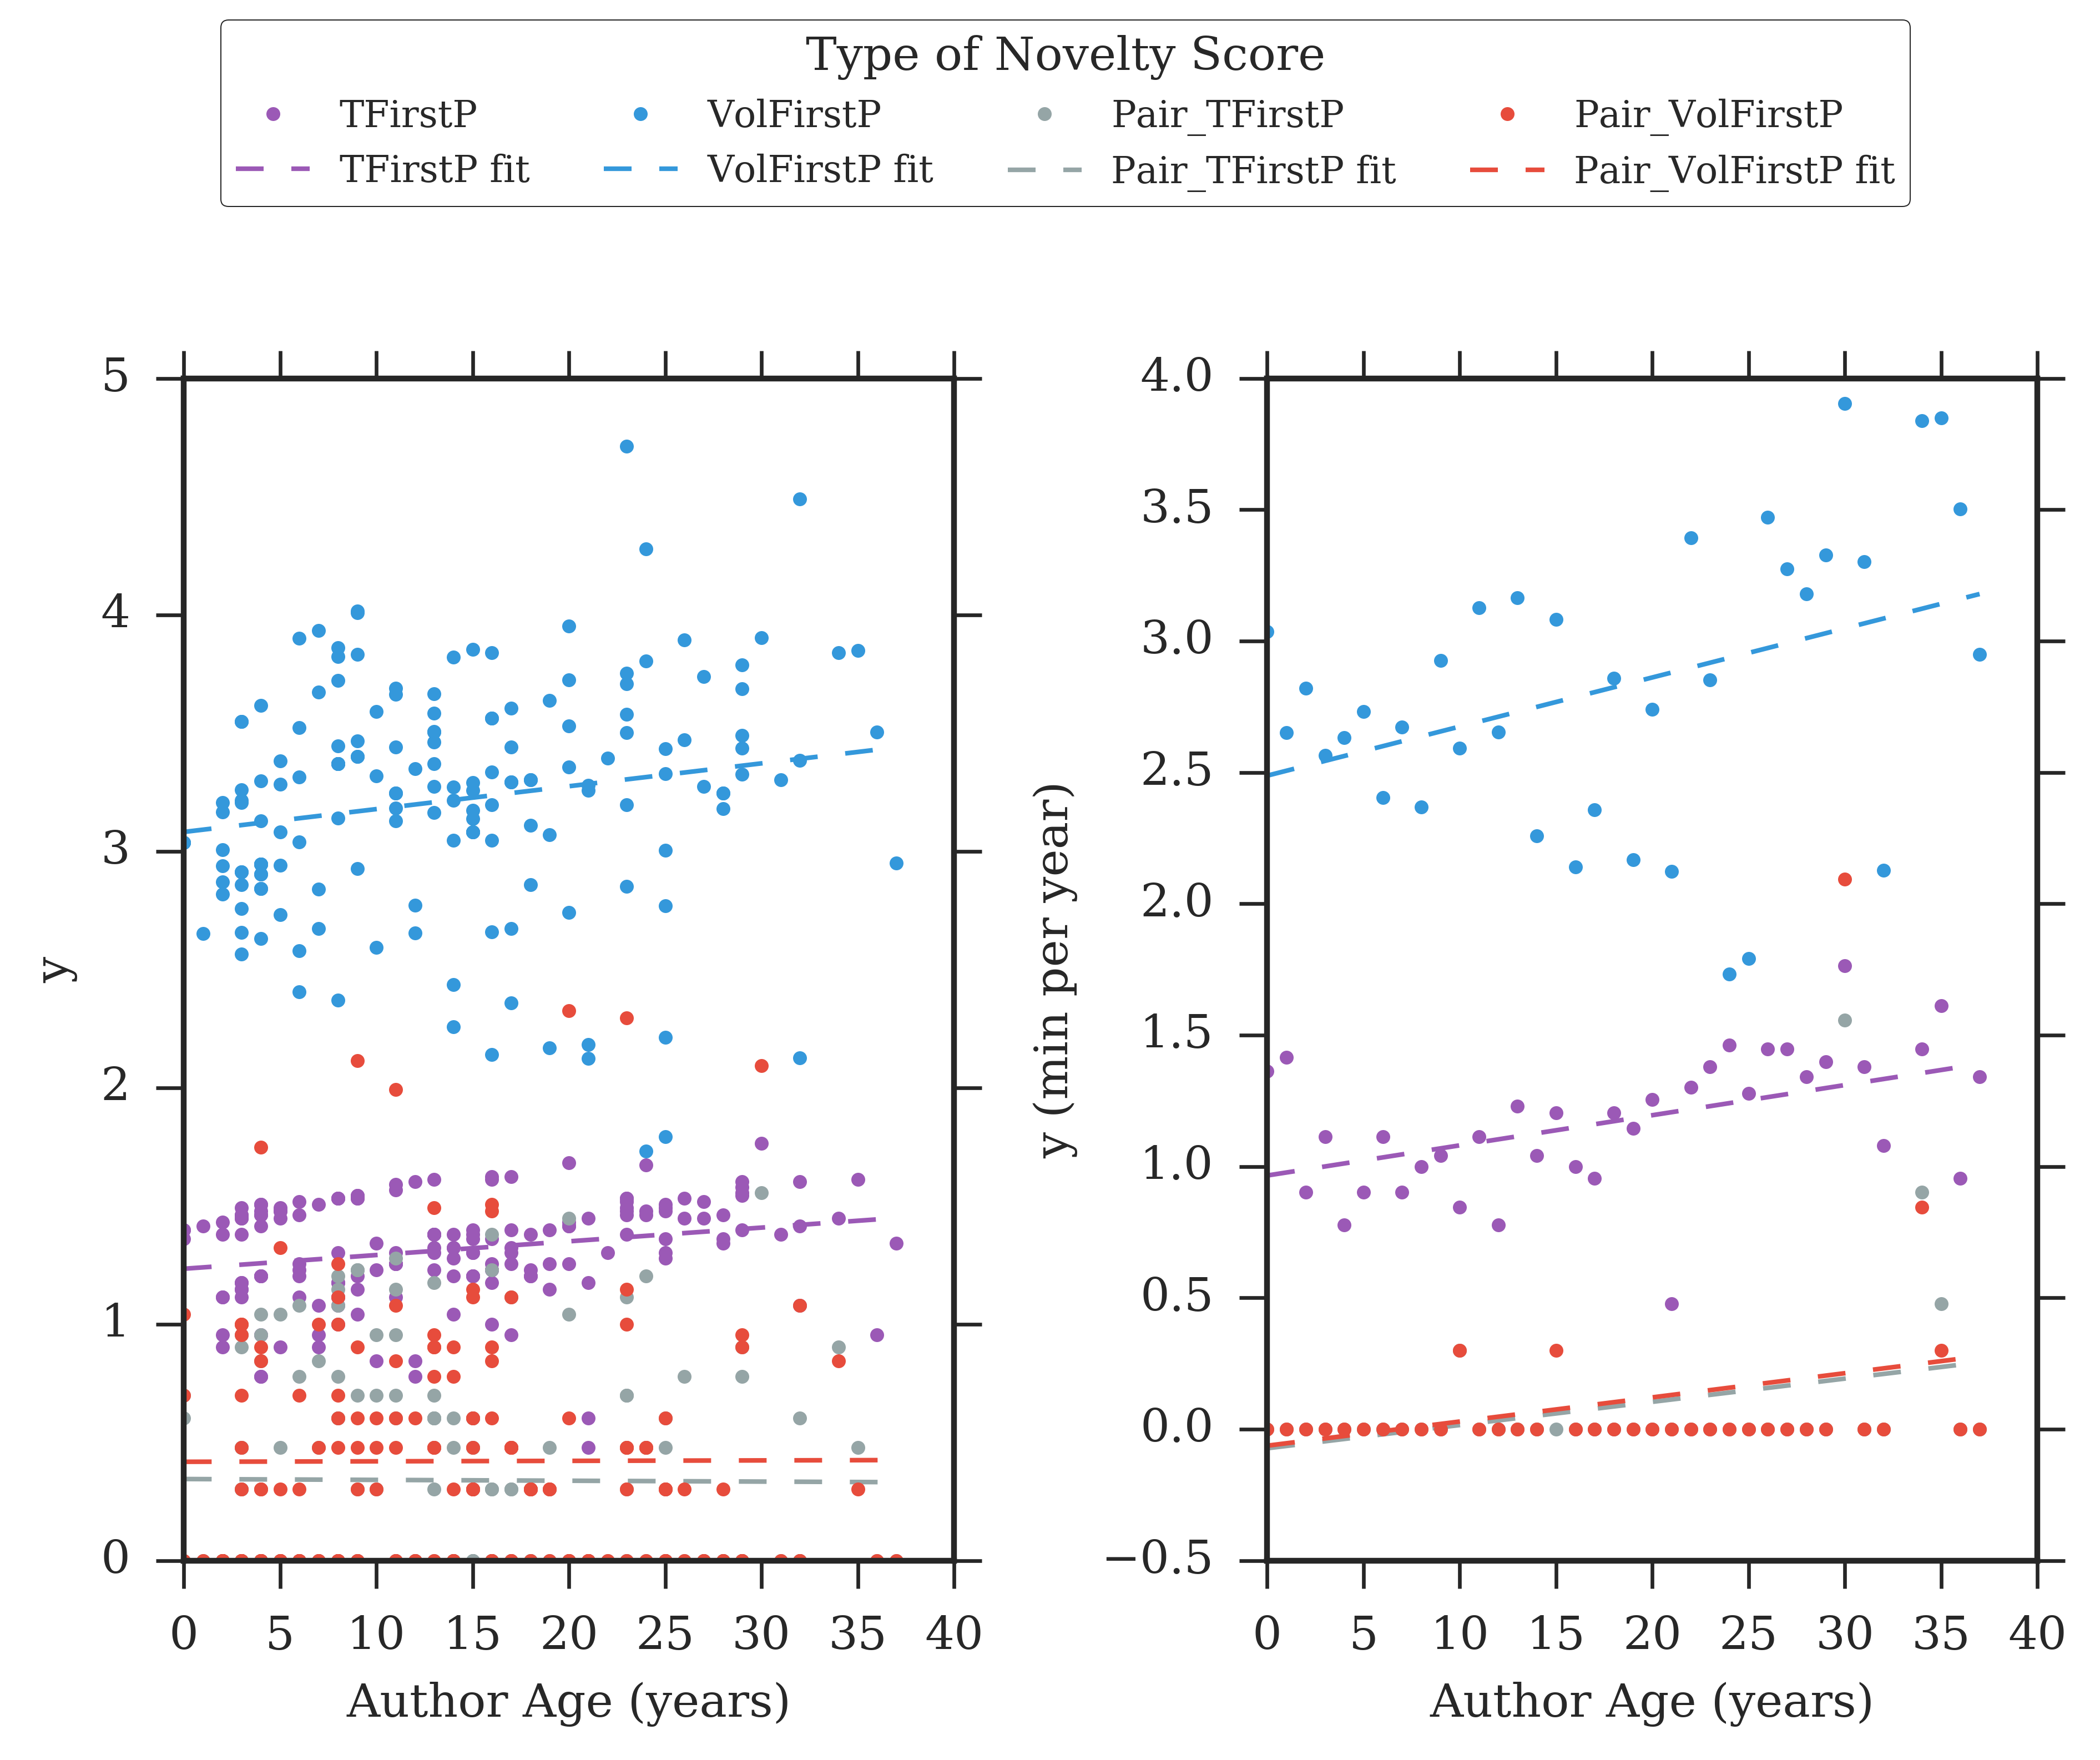

In [148]:
gen_coeffs(a[1], plot=True)

Avg per year models
TFirstP 0.00576012235284 1.15612333656
VolFirstP 0.0400174729003 2.27061428622
Pair_TFirstP -0.0026839559008 0.380272912248
Pair_VolFirstP 0.00226589032729 0.268009436325
Min per year models
TFirstP -0.0185034223845 1.3891404441
VolFirstP -0.0157899024179 2.75568251879
Pair_TFirstP -0.0241489911045 0.626210913735
Pair_VolFirstP -0.0149489523017 0.421386092475


(u'7469945_2',
 1980,
 147,
 0.005760122352842071,
 1.1561233365579975,
 0.040017472900311997,
 2.2706142862173042,
 -0.0026839559007958043,
 0.38027291224834397,
 0.0022658903272948241,
 0.26800943632499913,
 -0.018503422384487361,
 1.3891404440967159,
 -0.015789902417921692,
 2.755682518791406,
 -0.024148991104453562,
 0.62621091373549731,
 -0.014948952301686474,
 0.42138609247505981)

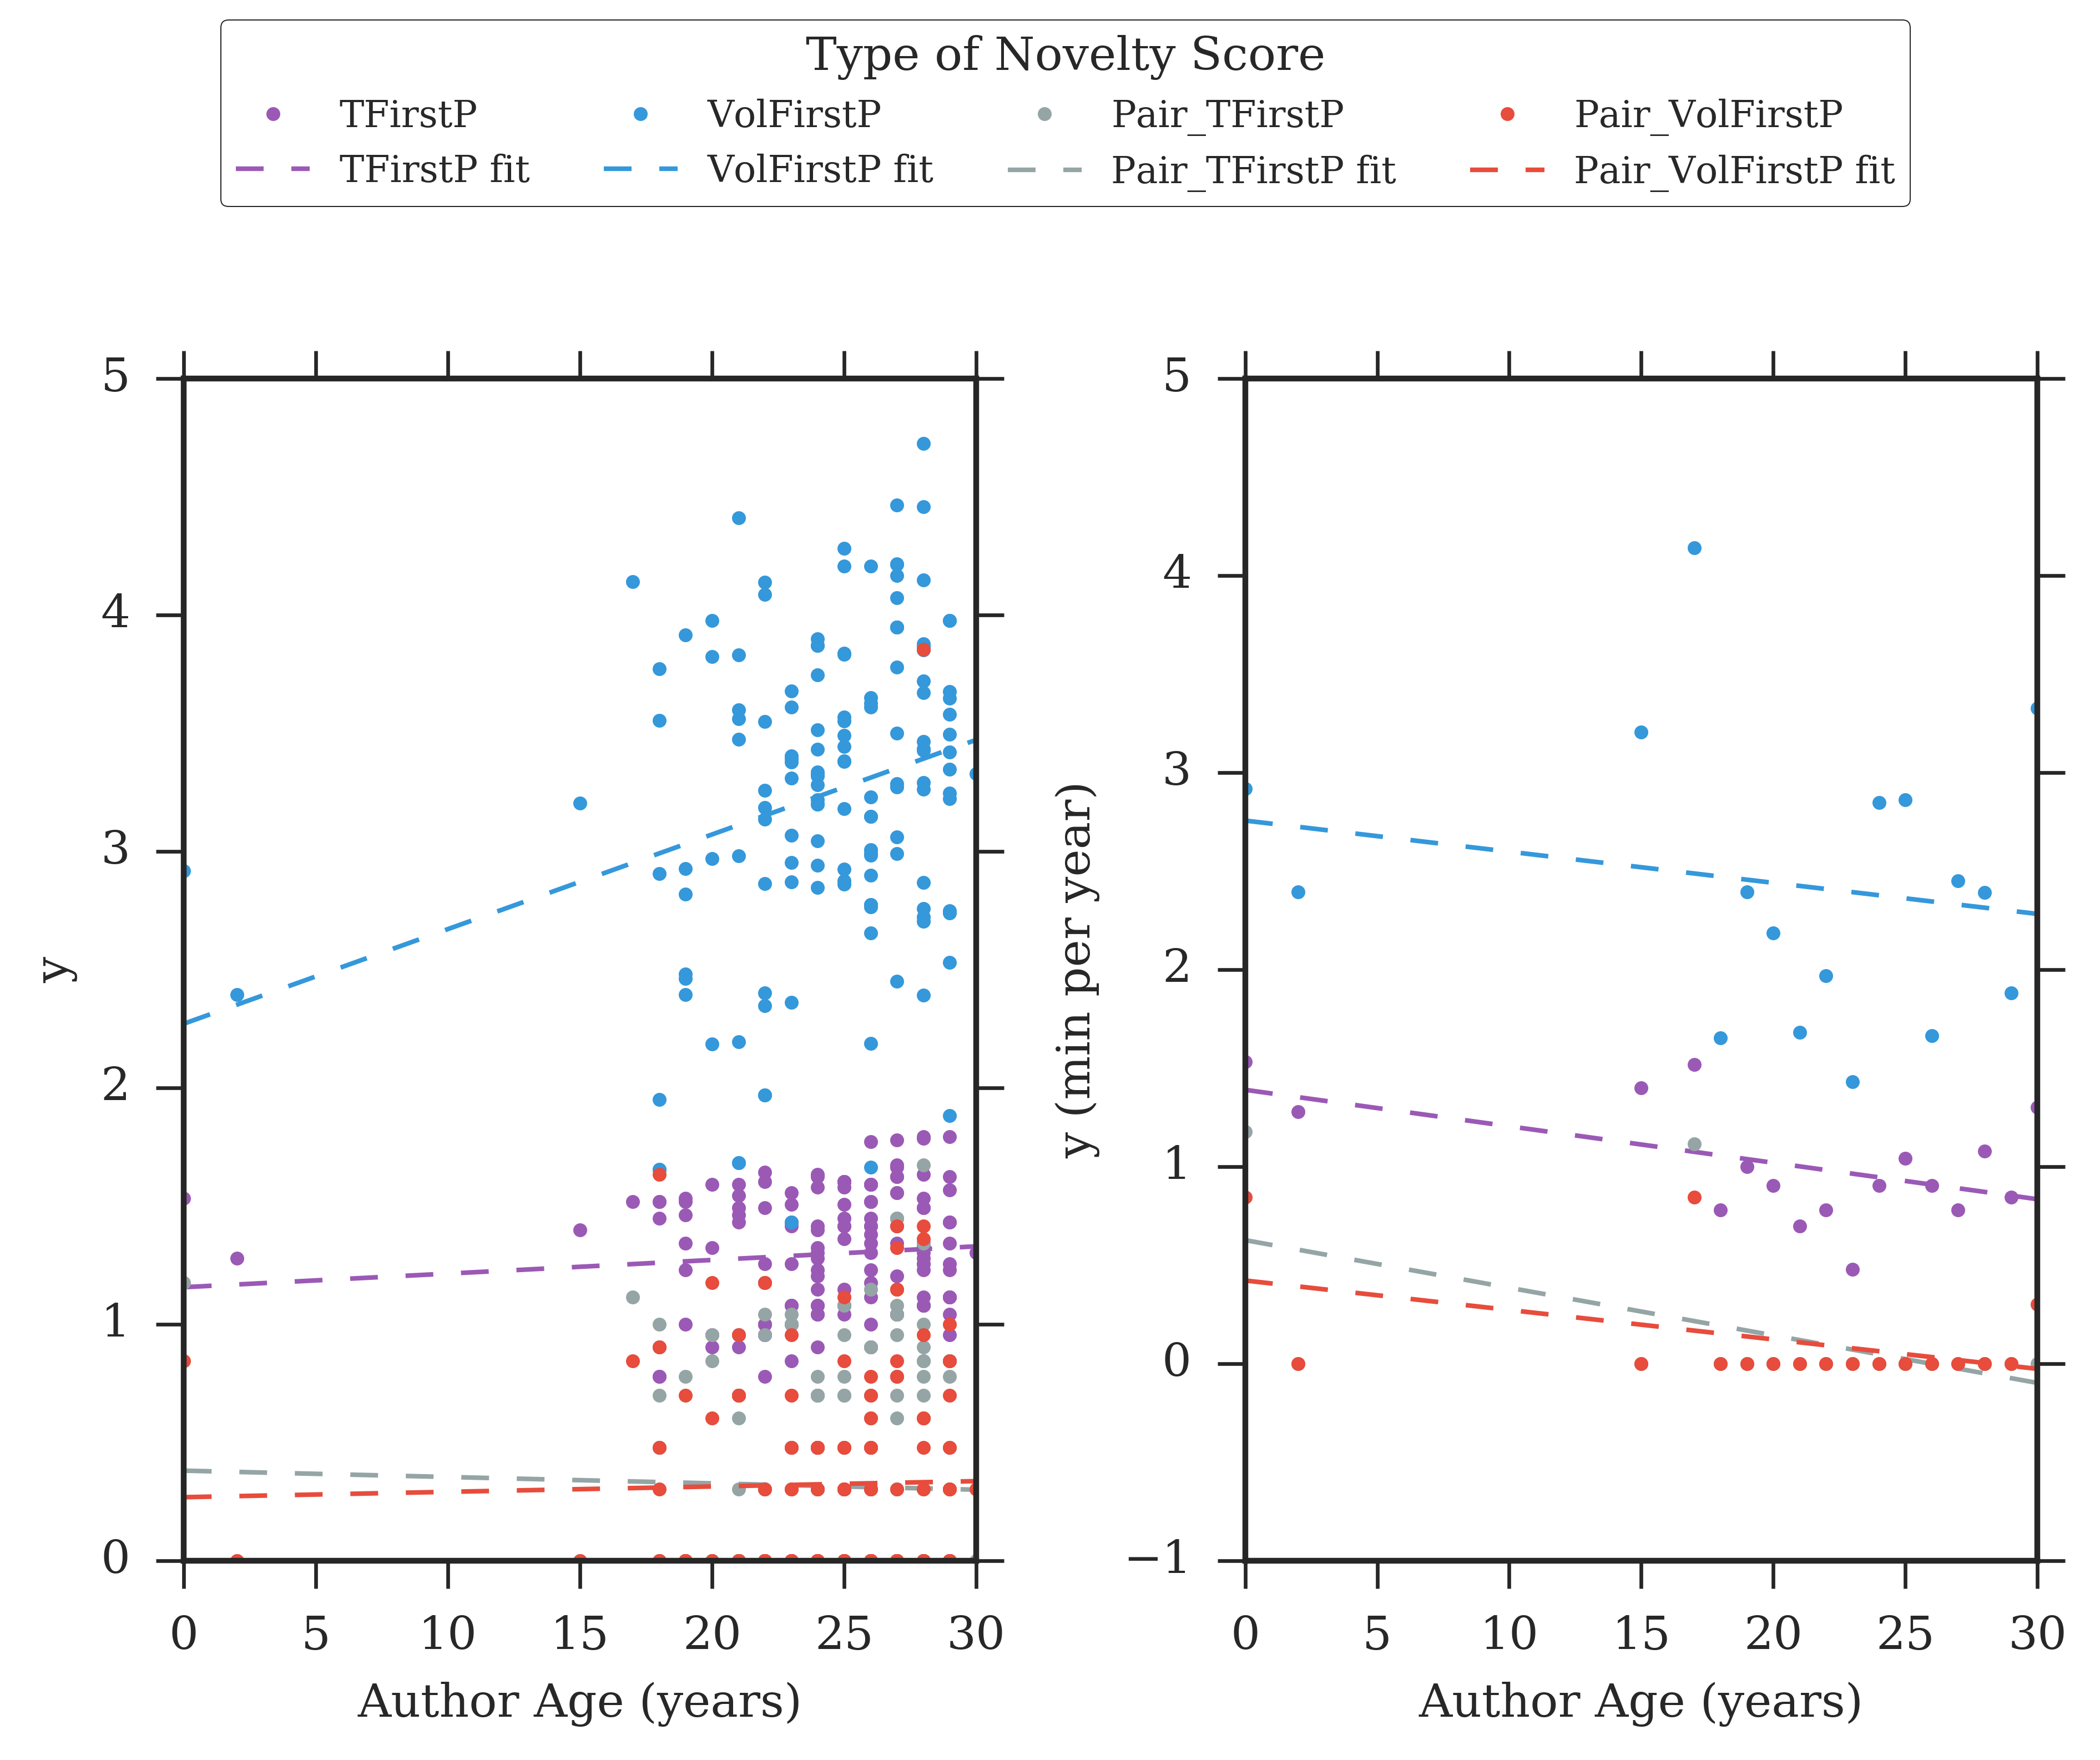

In [149]:
gen_coeffs(a[2], plot=True)

In [156]:
t = pd.DataFrame(a[0][1], columns=["first_yr", "num_papers", "year", "age_yr",
                   "TFirstP", "VolFirstP", "Pair_TFirstP", "Pair_VolFirstP"])

In [157]:
t.head()

first_yr  num_papers  year  age_yr  TFirstP  VolFirstP  Pair_TFirstP  Pair_VolFirstP
0      1985          75  2002      17       37       4346             2               2
1      1985          75  2006      21       37       1232             0               1
2      1985          75  2000      15       37       3901            21              14
3      1985          75  2008      23       39       1321             0               1
4      1985          75  1987       2       37       7956             1               5

In [158]:
t = t.groupby("age_yr").min()
t

first_yr  num_papers  year  TFirstP  VolFirstP  Pair_TFirstP  Pair_VolFirstP
age_yr                                                                              
0           1985          75  1985        5        169             0               1
1           1985          75  1986       15        191             0               1
2           1985          75  1987       37       7956             1               5
3           1985          75  1988       37        719            14               3
4           1985          75  1989       11        130             0               1
5           1985          75  1990       24        122             0               1
6           1985          75  1991       12        148             0               1
7           1985          75  1992       13        868             0               1
8           1985          75  1993       14        638             0               1
10          1985          75  1995        1         96             0               1
11          1985          75  1996        2        100             0               1
12          1985          75  1997       27       2667             0               1
13          1985          75  1998       21        306             0               1
15          1985          75  2000       17        221             0               1
16          1985          75  2001       22         78             0               1
17          1985          75  2002        9        162             0               1
18          1985          75  2003       40       4547            10               6
19          1985          75  2004       21        373             0               2
20          1985          75  2005        4         80             0               1
21          1985          75  2006       28        637             0               1
22          1985          75  2007        8        219             0               1
23          1985          75  2008       27        779             0               1
24          1985          75  2009       39       1726             0               1

In [159]:
t.idxmin()

first_yr           0
num_papers         0
year               0
TFirstP           10
VolFirstP         16
Pair_TFirstP       0
Pair_VolFirstP     0
dtype: int64

In [162]:
t.idxmin()[["TFirstP", "VolFirstP"]].tolist()

[10, 16]

In [166]:
joined_data.reduceByKey(lambda x, y: x+y).map(gen_coeffs)\
    .map(lambda x: "\t".join("%s" for k in xrange(len(x))) % x).saveAsTextFile("out/author_50_1965_coeffs")

In [167]:
# Fit models using RLM

joined_data.reduceByKey(lambda x, y: x+y).map(lambda x: gen_coeffs(x, model=RLM))\
    .map(lambda x: "\t".join("%s" for k in xrange(len(x))) % x).saveAsTextFile("out/author_50_1965_coeffs_rlm")

# Analyze distribution of coefficients

In [239]:
cols = ["TFirstP", "VolFirstP", "Pair_TFirstP", "Pair_VolFirstP"]
def read_coeffs(x):
    x = x.split("\t")
    auid = x[0]
    first_yr, num_papers = [int(k) for k in x[1:3]]
    min_ages = [int(k) for k in x[3:7]]
    avg_coeffs = [float(k) if k != "None" else np.nan for k in x[7:15]]
    min_coeffs = [float(k) if k != "None" else np.nan for k in x[15:23]]
    return tuple([auid, first_yr, num_papers] + min_ages + avg_coeffs + min_coeffs)

def get_coeff_colnames():
    cols = ["TFirstP", "VolFirstP", "Pair_TFirstP", "Pair_VolFirstP"]
    c = ["auid", "first_yr", "num_papers"]
    c += ["age_%s" % k for k in cols]
    c += ["avg_%s_%s" % (p,k) for k in cols for p in ["m", "c"]]
    c += ["min_%s_%s" % (p,k) for k in cols for p in ["m", "c"]]
    return c

In [257]:
coeff_data = sc.textFile("out/author_50_1965_coeffs/part-*").map(read_coeffs)

In [258]:
pd.DataFrame(coeff_data.take(3), columns=get_coeff_colnames())

auid  first_yr  num_papers  age_TFirstP  age_VolFirstP  age_Pair_TFirstP  age_Pair_VolFirstP  avg_m_TFirstP  avg_c_TFirstP  avg_m_VolFirstP          ...           avg_m_Pair_VolFirstP  \
0  7343989_3      1981         106           10             21                 2                   2       0.005430       0.950437        -0.001364          ...                      -0.002693   
1  4654931_2      1972          60           23             23                 0                   0       0.010390       1.157709         0.009878          ...                      -0.010783   
2  7178781_1      1982          81           19             19                 2                   4       0.001361       1.296161         0.008284          ...                      -0.003948   

   avg_c_Pair_VolFirstP  min_m_TFirstP  min_c_TFirstP  min_m_VolFirstP  min_c_VolFirstP  min_m_Pair_TFirstP  min_c_Pair_TFirstP  min_m_Pair_VolFirstP  min_c_Pair_VolFirstP  
0              0.401625       0.003855       0.706521        -0.004803         2.473748           -0.003828            0.116042             -0.014290              0.320675  
1              0.792380       0.008788       1.079130        -0.003084         2.687435           -0.004554            0.436915             -0.011412              0.631876  
2              0.453059      -0.001344       1.169530         0.001703         2.814825           -0.016255            0.359461             -0.018119              0.417334  

[3 rows x 23 columns]

In [180]:
!pwd

/content/smishra8/PUBMED/PUBMED2015/Novelty


In [259]:
df_coeffs = pd.DataFrame(coeff_data.collect(), columns=get_coeff_colnames())

In [187]:
df_coeffs.shape

(154173, 23)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6cfc45e850>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6cf6a4eb10>]], dtype=object)

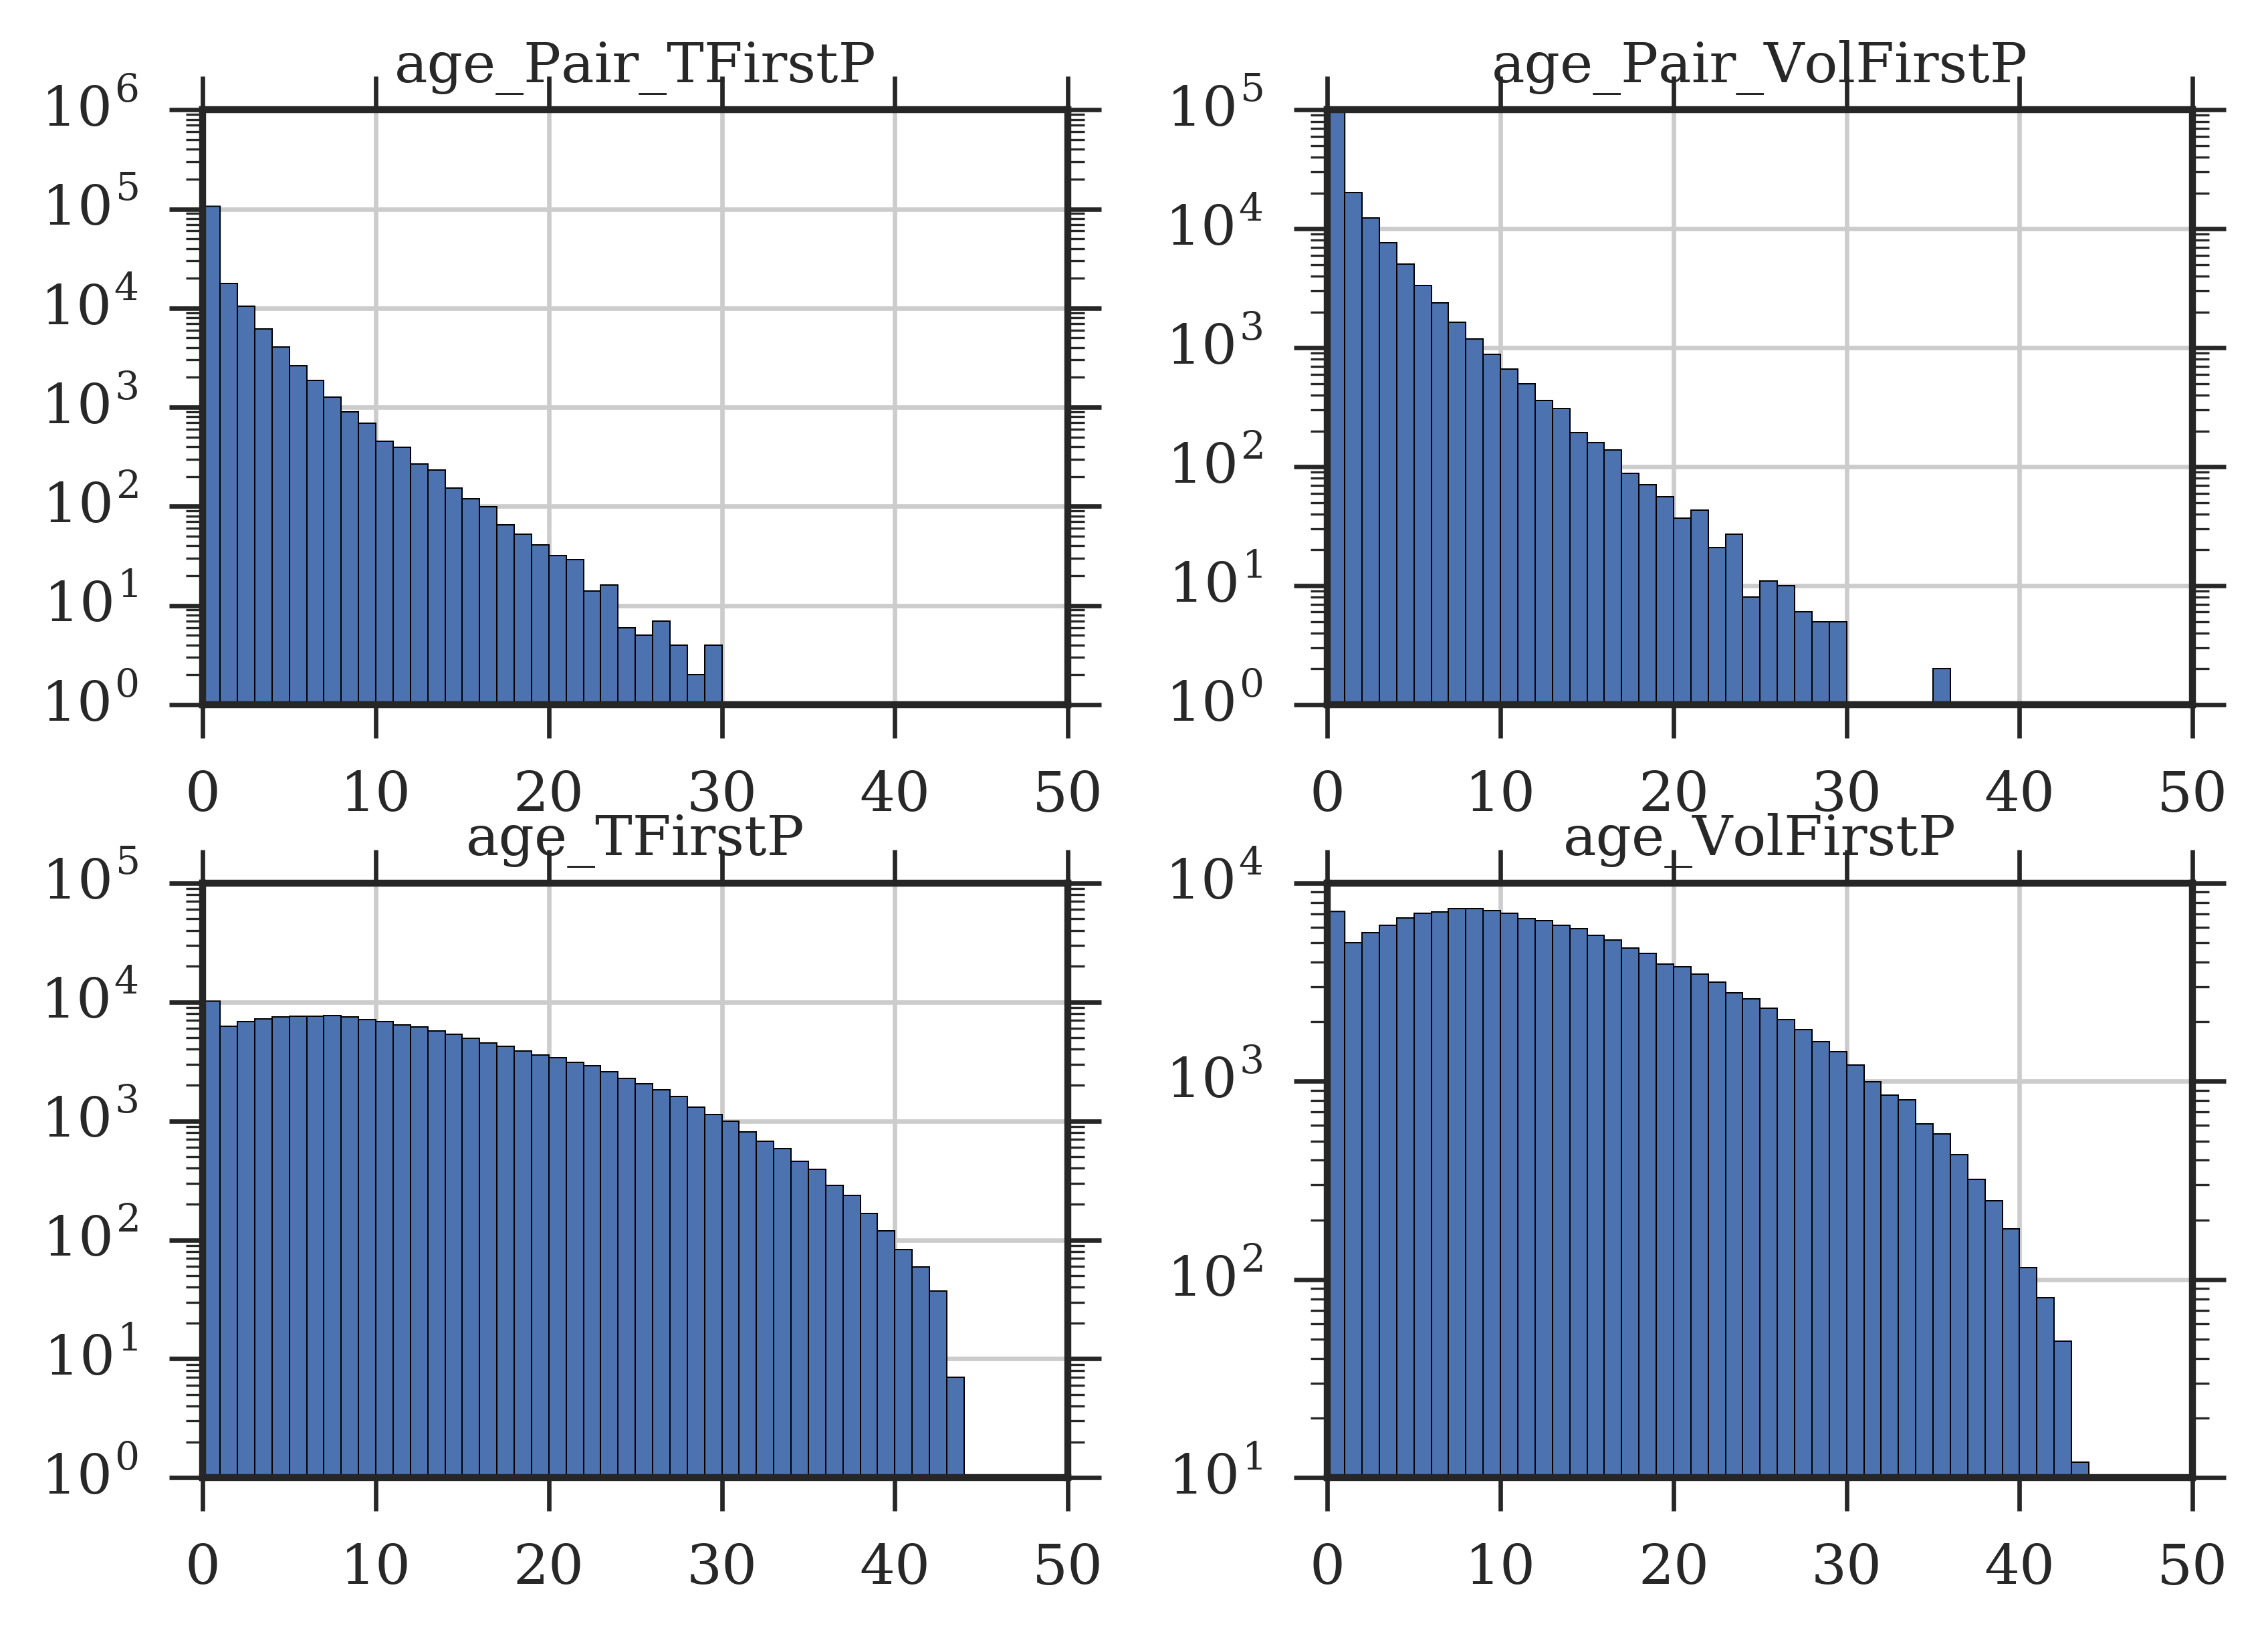

In [192]:
df_coeffs.hist(["age_%s" % k for k in cols], bins=range(50), log=True)

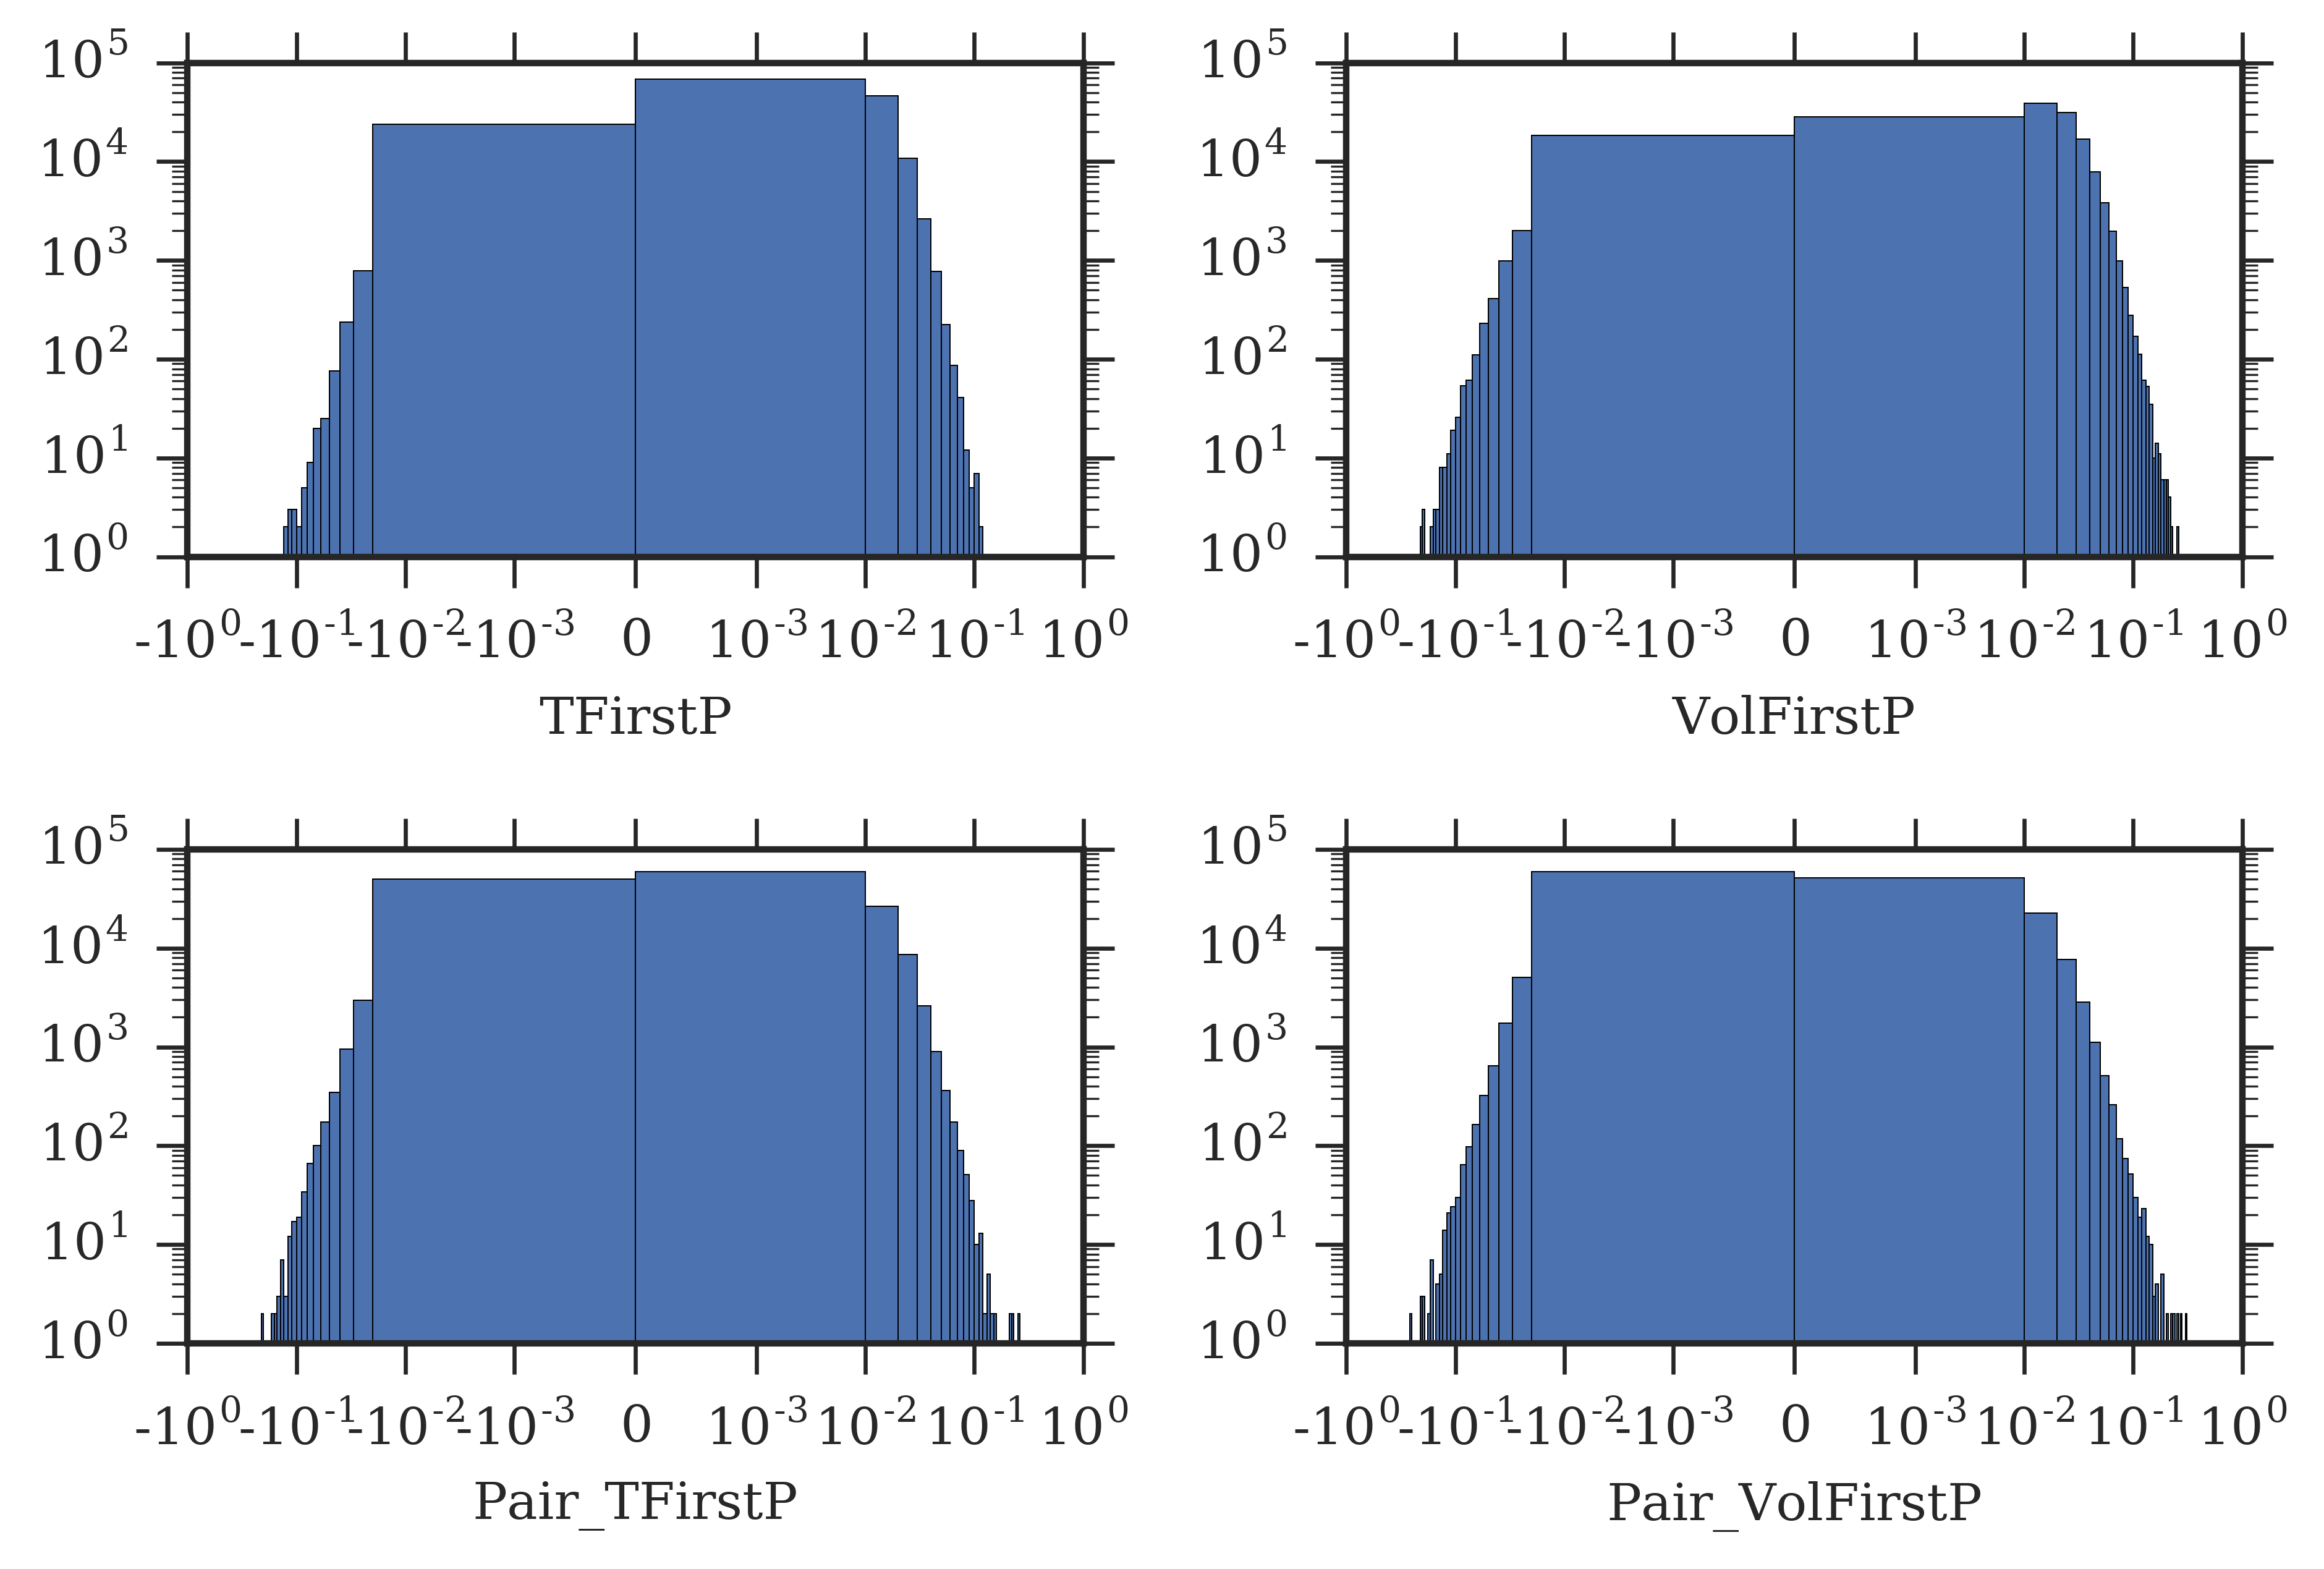

In [234]:
plt.close("all")
plt.clf()
fig, ax = plt.subplots(2,2)
for k, axi in zip(cols, ax.flatten()):
    axi.hist(df_coeffs["avg_m_%s" % k],
            bins=np.arange(-1,-0.01,0.01).tolist() + np.arange(0,1,0.01).tolist(),
            log=True)
    axi.set_xlabel(k)
    axi.set_xscale("symlog", linthreshx=1e-3)
fig.tight_layout()

In [223]:
for k in cols:
    t = pd.cut(df_coeffs["avg_m_%s" % k], bins=[-100.,0.,100.]).value_counts()
    print k
    print pd.DataFrame({"c": t, "%": t * 100./t.sum()})
    

TFirstP
                   %       c
(0, 100]   83.805206  129205
(-100, 0]  16.194794   24968
VolFirstP
                   %       c
(0, 100]   85.458543  131754
(-100, 0]  14.541457   22419
Pair_TFirstP
                   %      c
(0, 100]   64.285575  99111
(-100, 0]  35.714425  55062
Pair_VolFirstP
                  %      c
(0, 100]   56.25304  86727
(-100, 0]  43.74696  67446


In [235]:
for k in cols:
    t = pd.cut(df_coeffs["min_m_%s" % k], bins=[-100.,0.,100.]).value_counts()
    print k
    print pd.DataFrame({"c": t, "%": t * 100./t.sum()})

TFirstP
                   %      c
(0, 100]   58.999955  90962
(-100, 0]  41.000045  63211
VolFirstP
                   %      c
(0, 100]   58.337712  89941
(-100, 0]  41.662288  64232
Pair_TFirstP
                   %       c
(-100, 0]  67.312694  103778
(0, 100]   32.687306   50395
Pair_VolFirstP
                   %       c
(-100, 0]  68.794795  106063
(0, 100]   31.205205   48110


## RLM fitted models

In [240]:
df_coeffs = pd.DataFrame(
    sc.textFile("out/author_50_1965_coeffs_rlm/part-*").map(read_coeffs).collect(),
    columns=get_coeff_colnames())

In [242]:
print "Avg coeffs"
for k in cols:
    t = pd.cut(df_coeffs["avg_m_%s" % k], bins=[-100.,0.,100.]).value_counts()
    print k
    print pd.DataFrame({"c": t, "%": t * 100./t.sum()})

print "Min coeffs"
for k in cols:
    t = pd.cut(df_coeffs["min_m_%s" % k], bins=[-100.,0.,100.]).value_counts()
    print k
    print pd.DataFrame({"c": t, "%": t * 100./t.sum()})

Avg coeffs
TFirstP
                   %       c
(0, 100]   84.393506  130112
(-100, 0]  15.606494   24061
VolFirstP
                   %       c
(0, 100]   85.185377  131332
(-100, 0]  14.814623   22840
Pair_TFirstP
                   %      c
(0, 100]   61.851451  95357
(-100, 0]  38.148549  58814
Pair_VolFirstP
                   %      c
(0, 100]   56.257946  86734
(-100, 0]  43.742054  67438
Min coeffs
TFirstP
                   %      c
(0, 100]   59.265073  91366
(-100, 0]  40.734927  62799
VolFirstP
                   %      c
(0, 100]   58.458145  90122
(-100, 0]  41.541855  64043
Pair_TFirstP
                  %      c
(-100, 0]  62.26283  84500
(0, 100]   37.73717  51215
Pair_VolFirstP
                   %      c
(-100, 0]  64.420654  91525
(0, 100]   35.579346  50549


Results of RLM fitted models are similar to OLS. Will use OLS model results.

### Find year of most novel paper

In [282]:
df_t = df_coeffs.pivot_table(values="auid",
               index=(df_coeffs.first_yr + df_coeffs.age_TFirstP),
               columns=pd.cut(df_coeffs.first_yr, bins=range(1965,2015,5), include_lowest=True),
               aggfunc=len)

In [279]:
from cycler import cycler

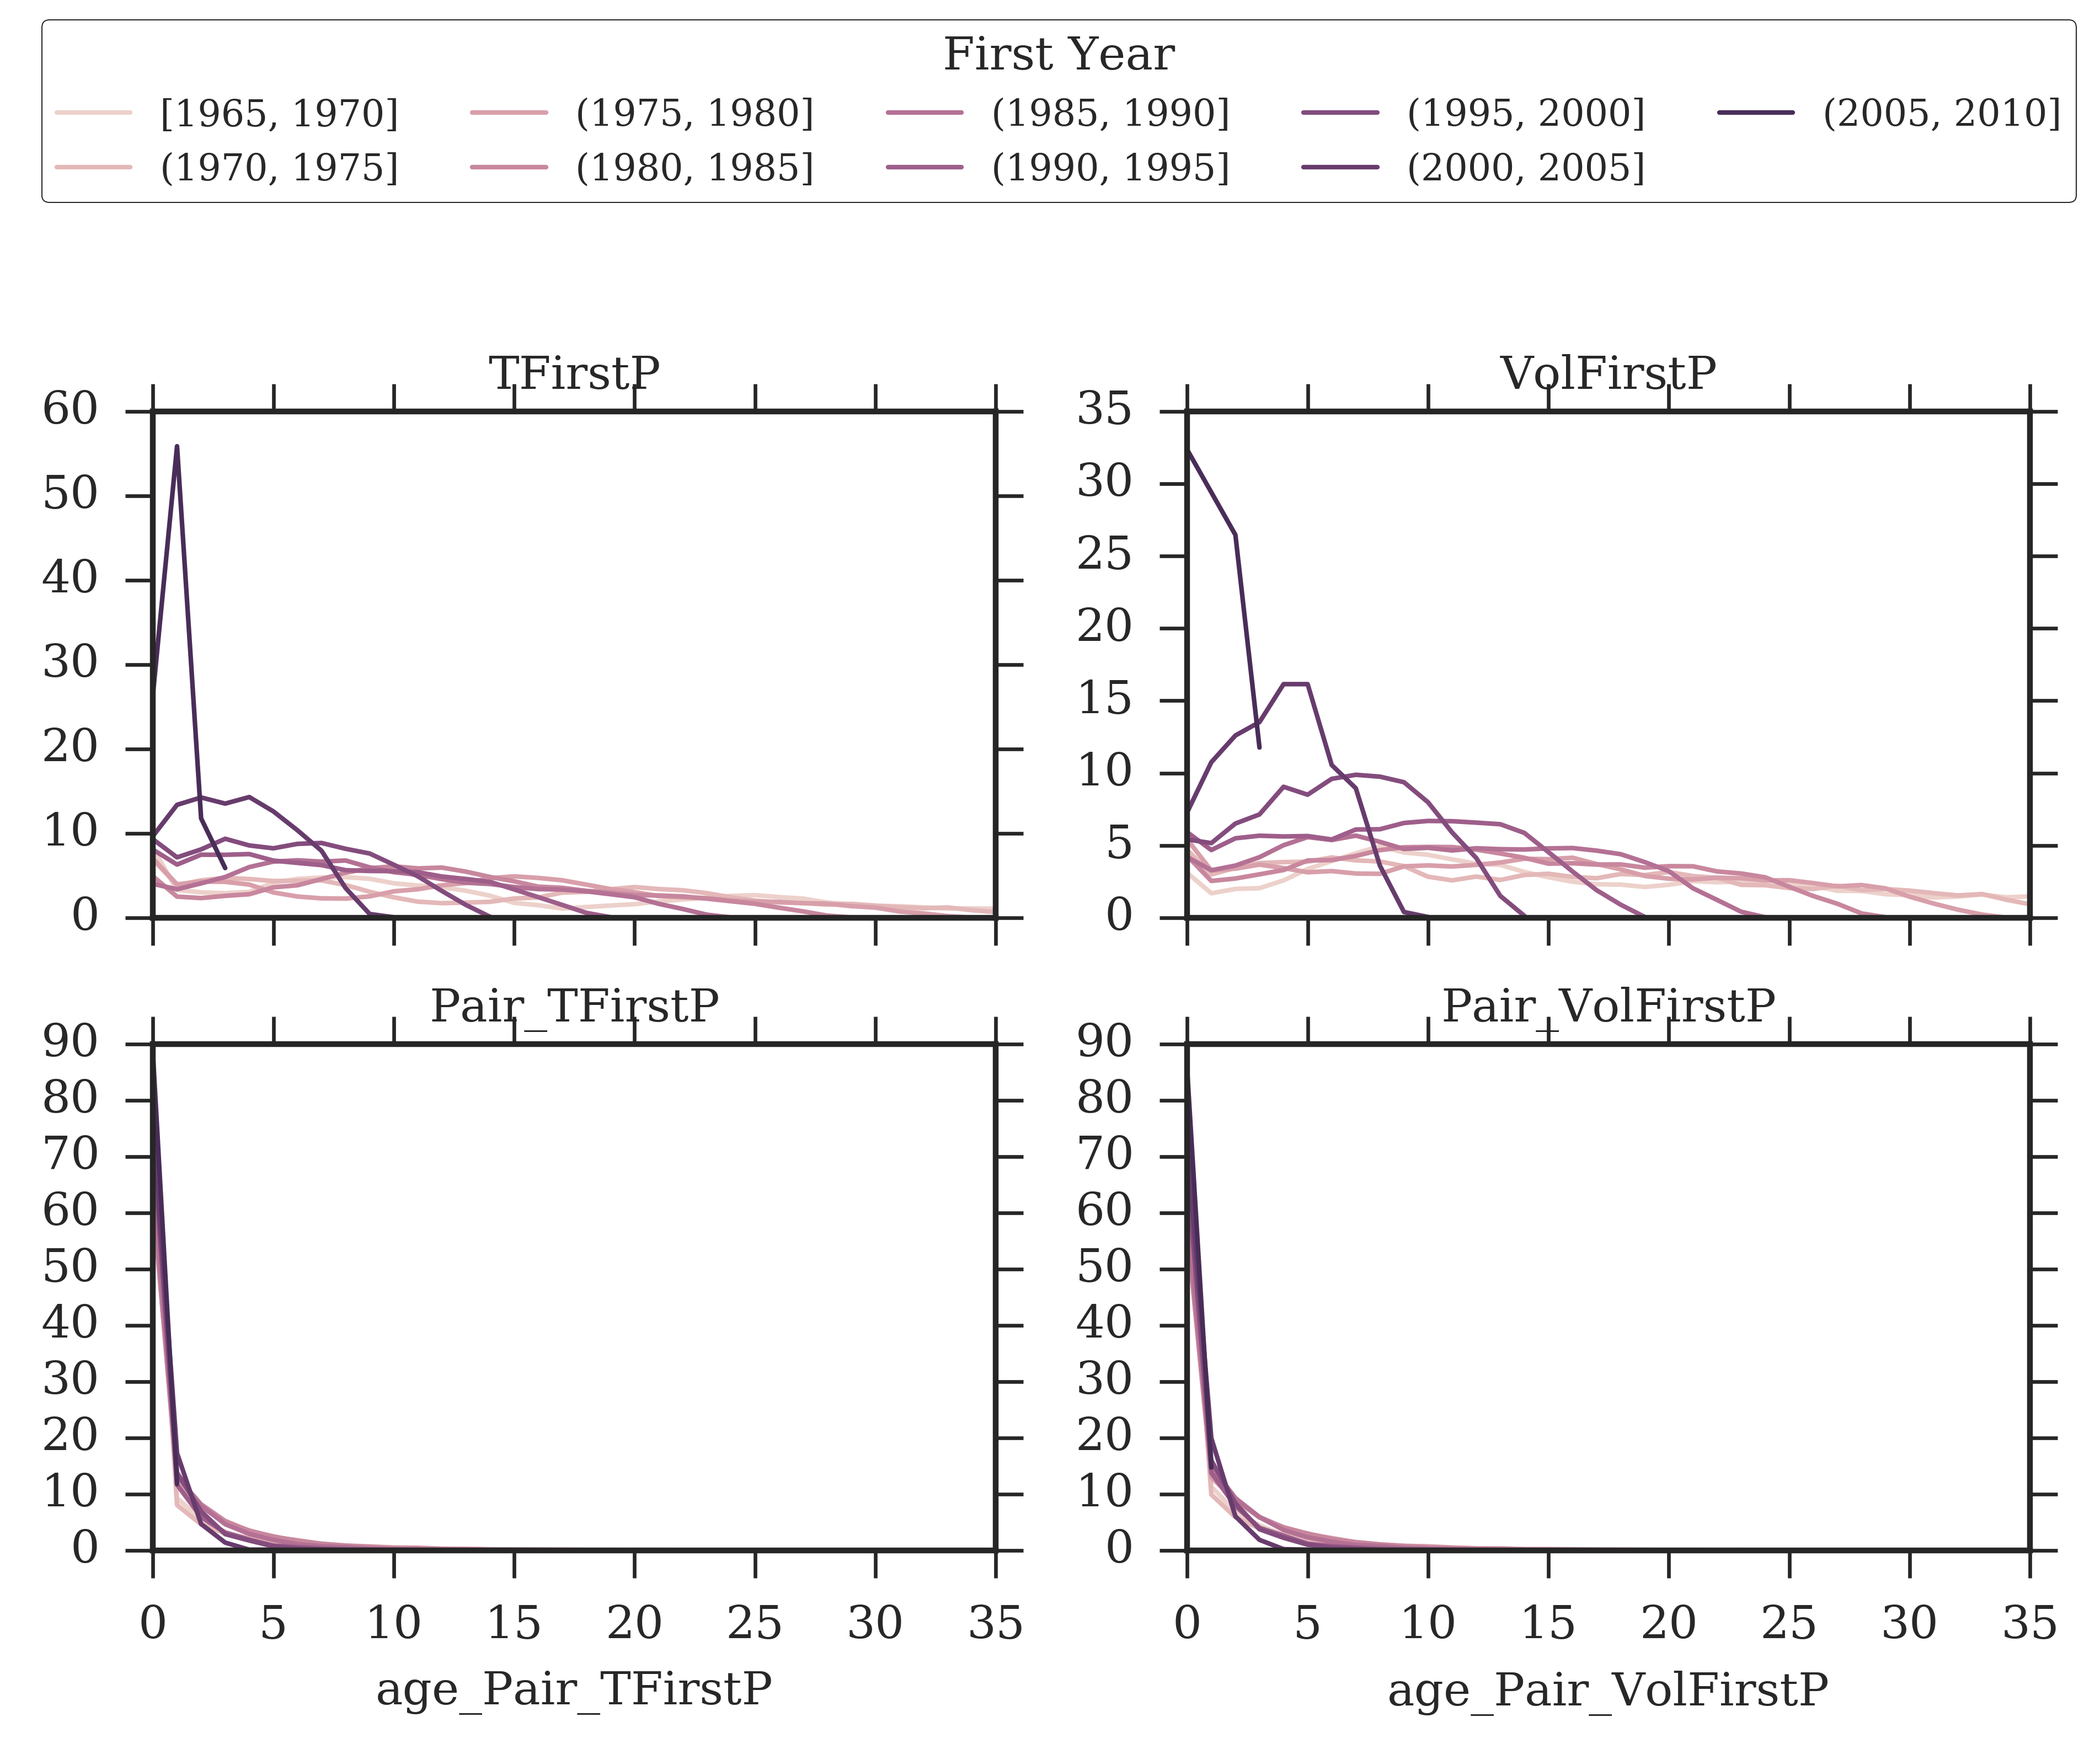

In [290]:
fig, ax = plt.subplots(2,2, sharex=True)
for k, axi in zip(cols, ax.flatten()):
    df_t = df_coeffs.pivot_table(values="auid",
               index=(df_coeffs["age_%s" % k]),
               columns=pd.cut(df_coeffs.first_yr, bins=range(1965,2015,5), include_lowest=True),
               aggfunc=len)
    axi.set_prop_cycle(cycler("color", sns.cubehelix_palette(10)))
    axi.set_title(k)
    (df_t.divide(df_t.sum(axis=0), axis=1) * 100).plot(ax=axi, legend=False)
lgd = fig.legend(*axi.get_legend_handles_labels(),
    loc = 'upper center',bbox_to_anchor=(0.5, 1.2),
    title = "First Year",
    ncol=5, frameon=True, fancybox=True)
fig.tight_layout()
plt.show()

## Test mean of log versus simple mean

In [310]:
x = 100*np.random.rand(1000)
x = np.concatenate([np.random.poisson(10,1000), 20*np.ones(50)])

65 139
2 1000
3 300
10 200


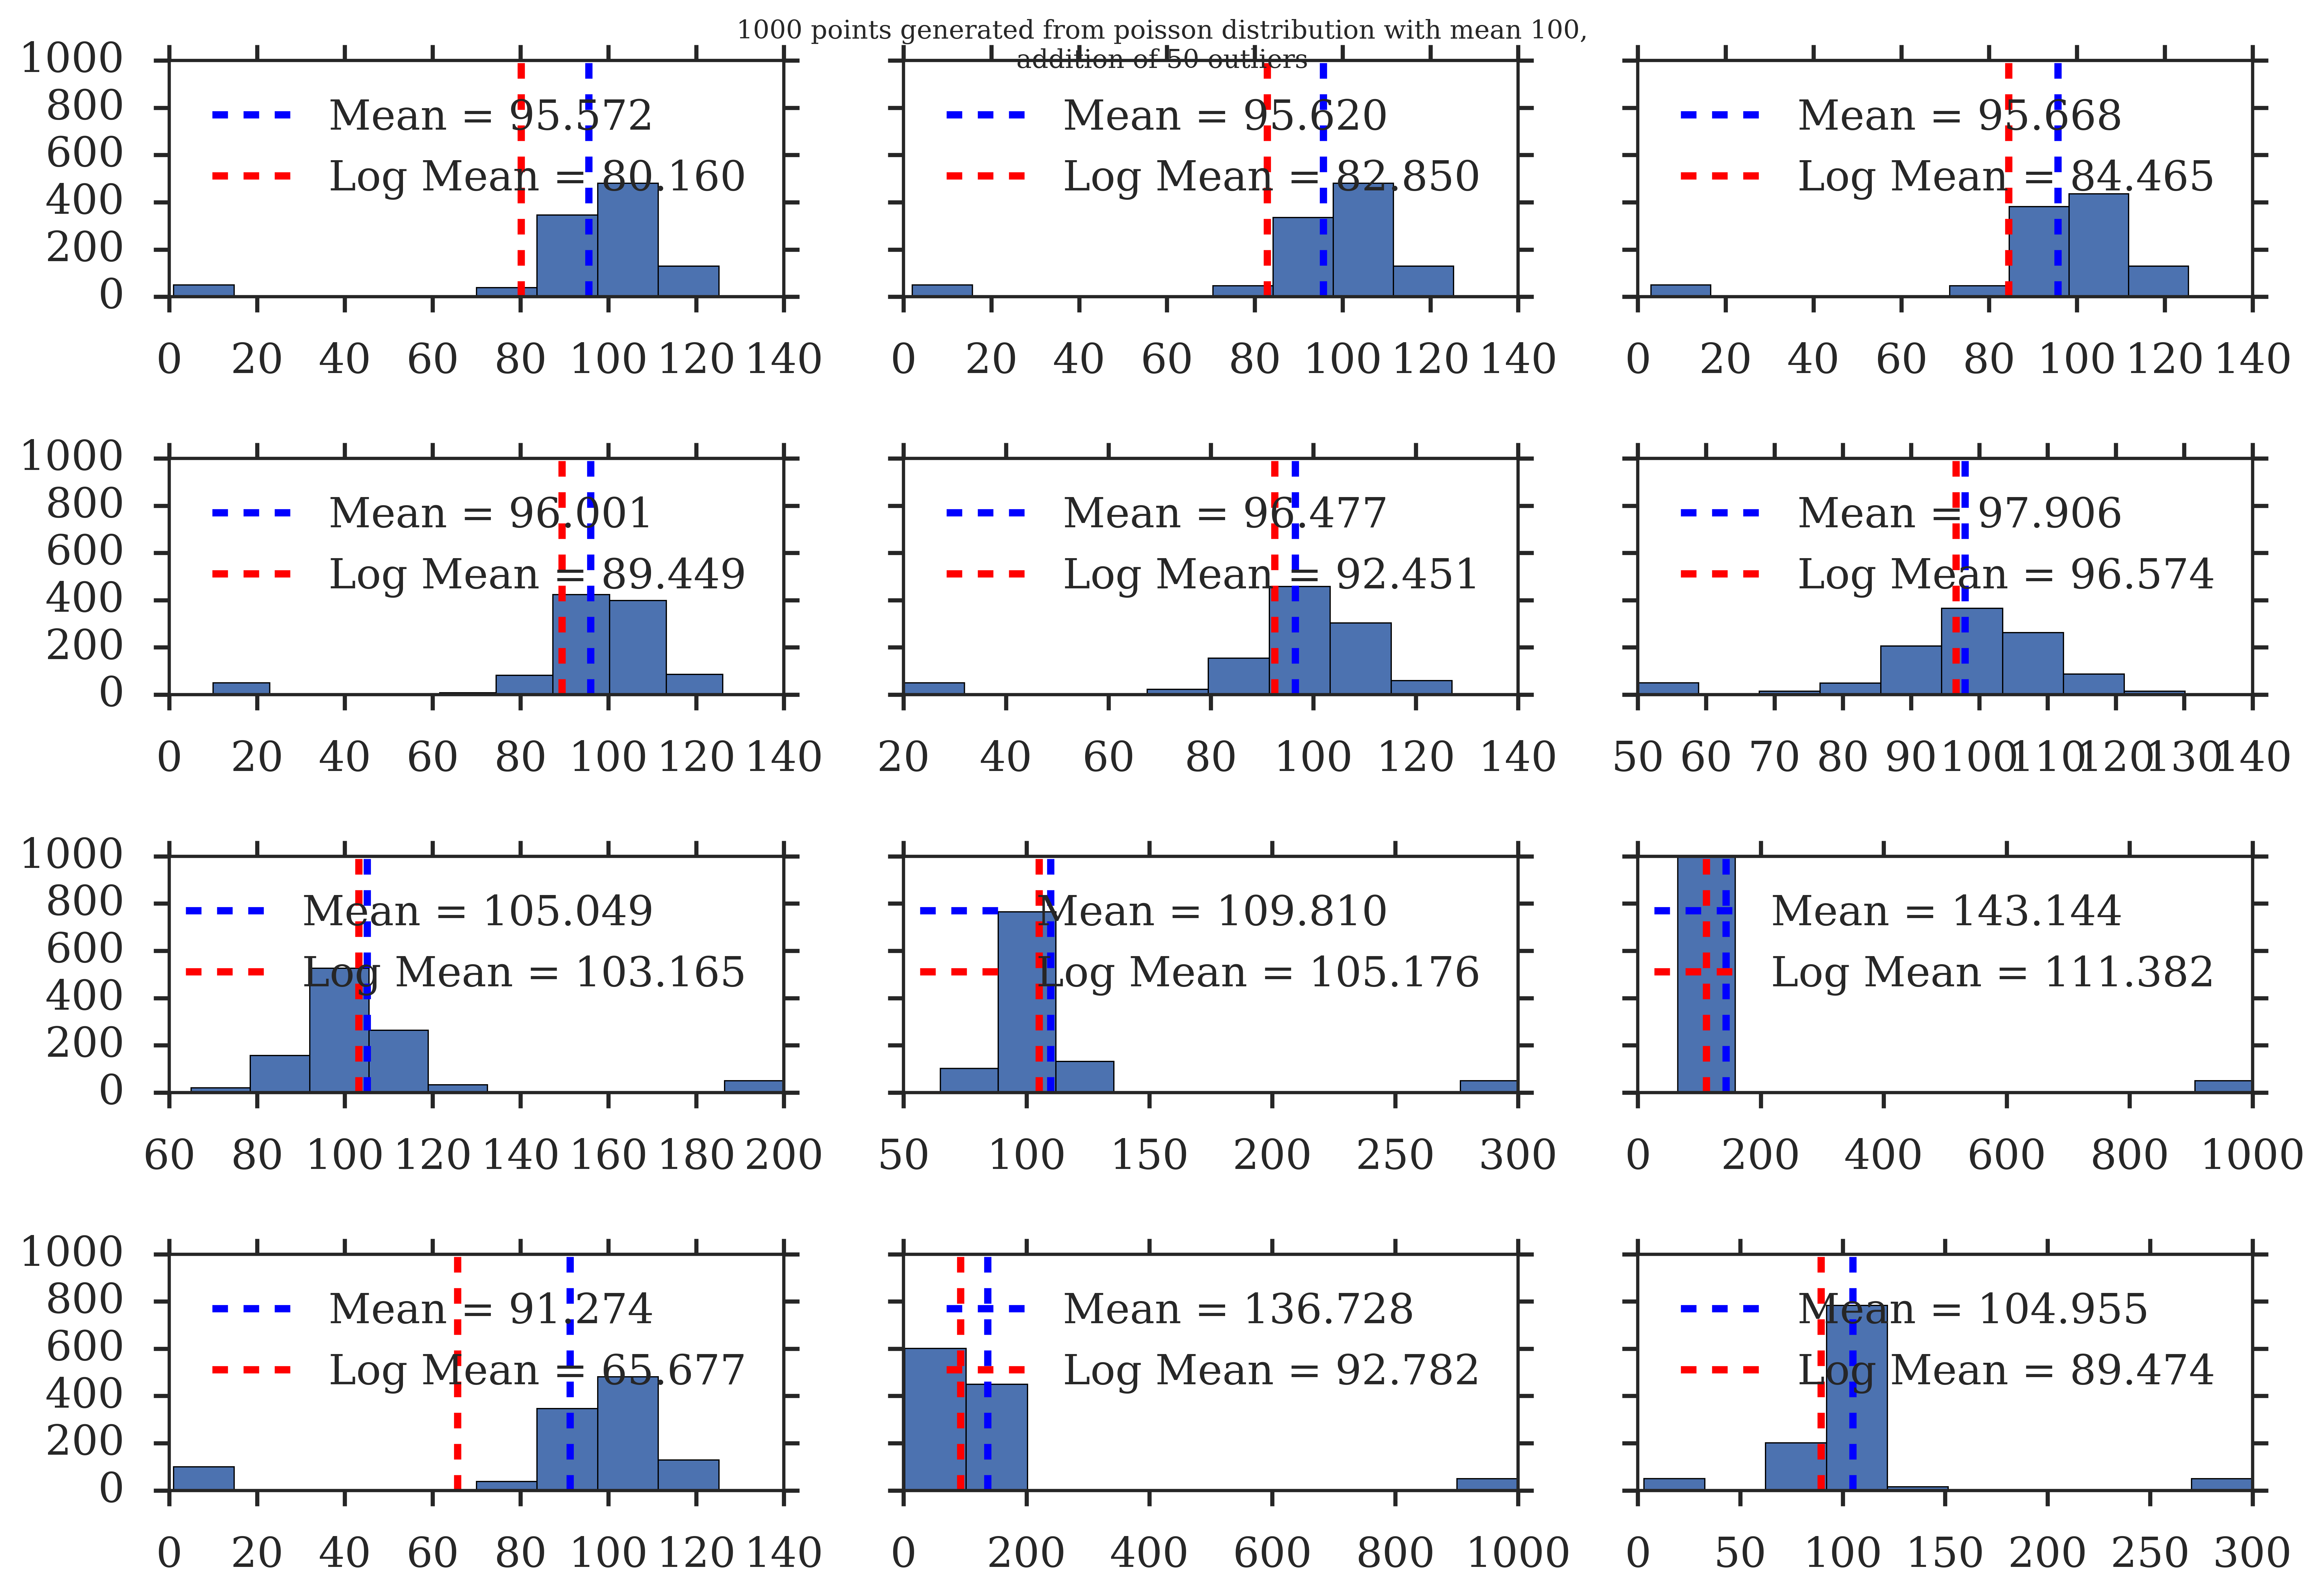

In [329]:
with sns.plotting_context("poster"):
    plt.close("all")
    plt.clf()
    fig, ax = plt.subplots(4,3, sharey=True)
    base_x = np.random.poisson(100,1000)
    print base_x.min(), base_x.max()
    outliers_x = [1,2,3,10,20,50,200,300,1000]
    k = None
    for i, axi in enumerate(ax.flatten()):
        if i/3 == 3:
            x = np.concatenate([base_x, outliers_x[i%3]*np.ones(50), outliers_x[-(i%3)]*np.ones(50)])
            print outliers_x[1 + i%3], outliers_x[-(1 + i%3)]
        else:
            k = outliers_x[i]
            x = np.concatenate([base_x, k*np.ones(50)])
        axi.hist(x)
        axi.axvline(x=x.mean(), linestyle="--", color="b",
                    label="Mean = %.3f" % x.mean())
        axi.axvline(x=10**(np.log10(x).mean()), linestyle="--", color="r",
                    label="Log Mean = %.3f" % 10**(np.log10(x).mean()))
        axi.legend()
    fig.suptitle("%s points generated from poisson distribution with mean %s,\naddition of %s outliers" % (1000,100,50))
    fig.tight_layout()


73 132
2 1000
3 300
10 200


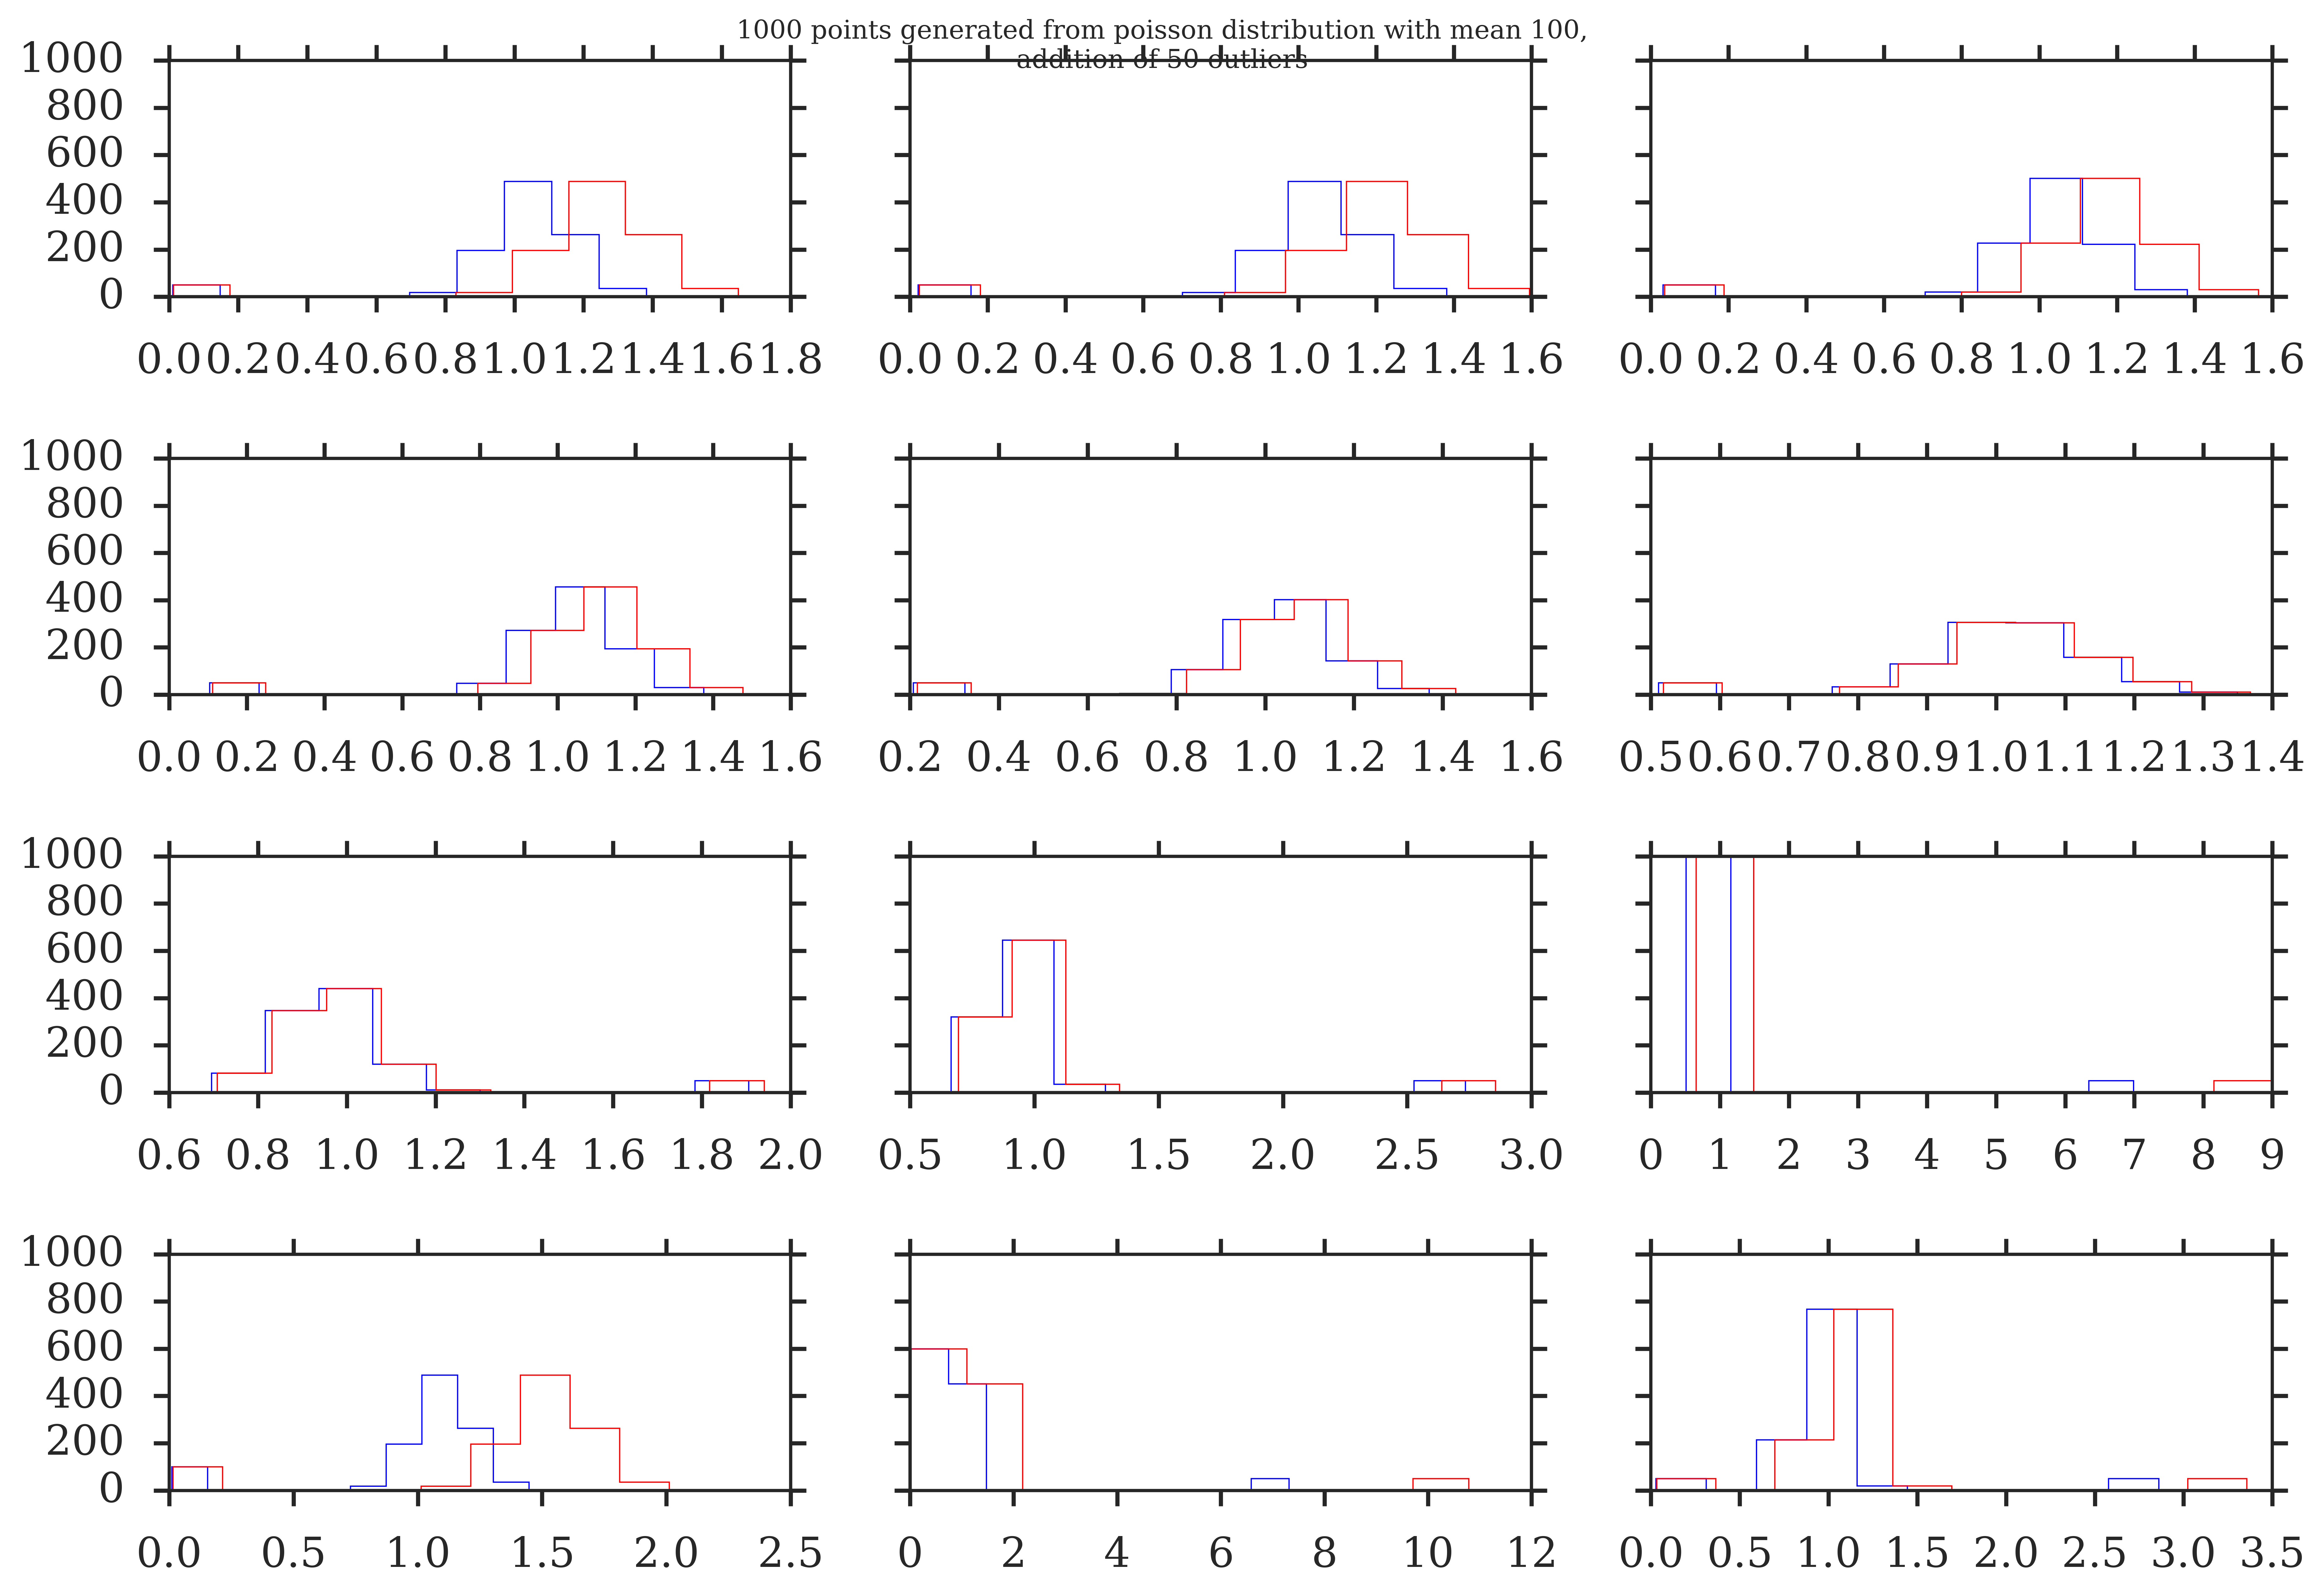

In [330]:
with sns.plotting_context("poster"):
    plt.close("all")
    plt.clf()
    fig, ax = plt.subplots(4,3, sharey=True)
    base_x = np.random.poisson(100,1000)
    print base_x.min(), base_x.max()
    outliers_x = [1,2,3,10,20,50,200,300,1000]
    k = None
    for i, axi in enumerate(ax.flatten()):
        if i/3 == 3:
            x = np.concatenate([base_x, outliers_x[i%3]*np.ones(50), outliers_x[-(i%3)]*np.ones(50)])
            print outliers_x[1 + i%3], outliers_x[-(1 + i%3)]
        else:
            k = outliers_x[i]
            x = np.concatenate([base_x, k*np.ones(50)])
        axi.hist(x/x.mean(), histtype="step", color="b")
        axi.hist(x/(10**(np.log10(x).mean())), histtype="step", color="r")
    fig.suptitle("%s points generated from poisson distribution with mean %s,\naddition of %s outliers" % (1000,100,50))
    fig.tight_layout()


In [349]:
x = 2*np.random.randn(1000) + 5
y = 10**(3*x + 2)

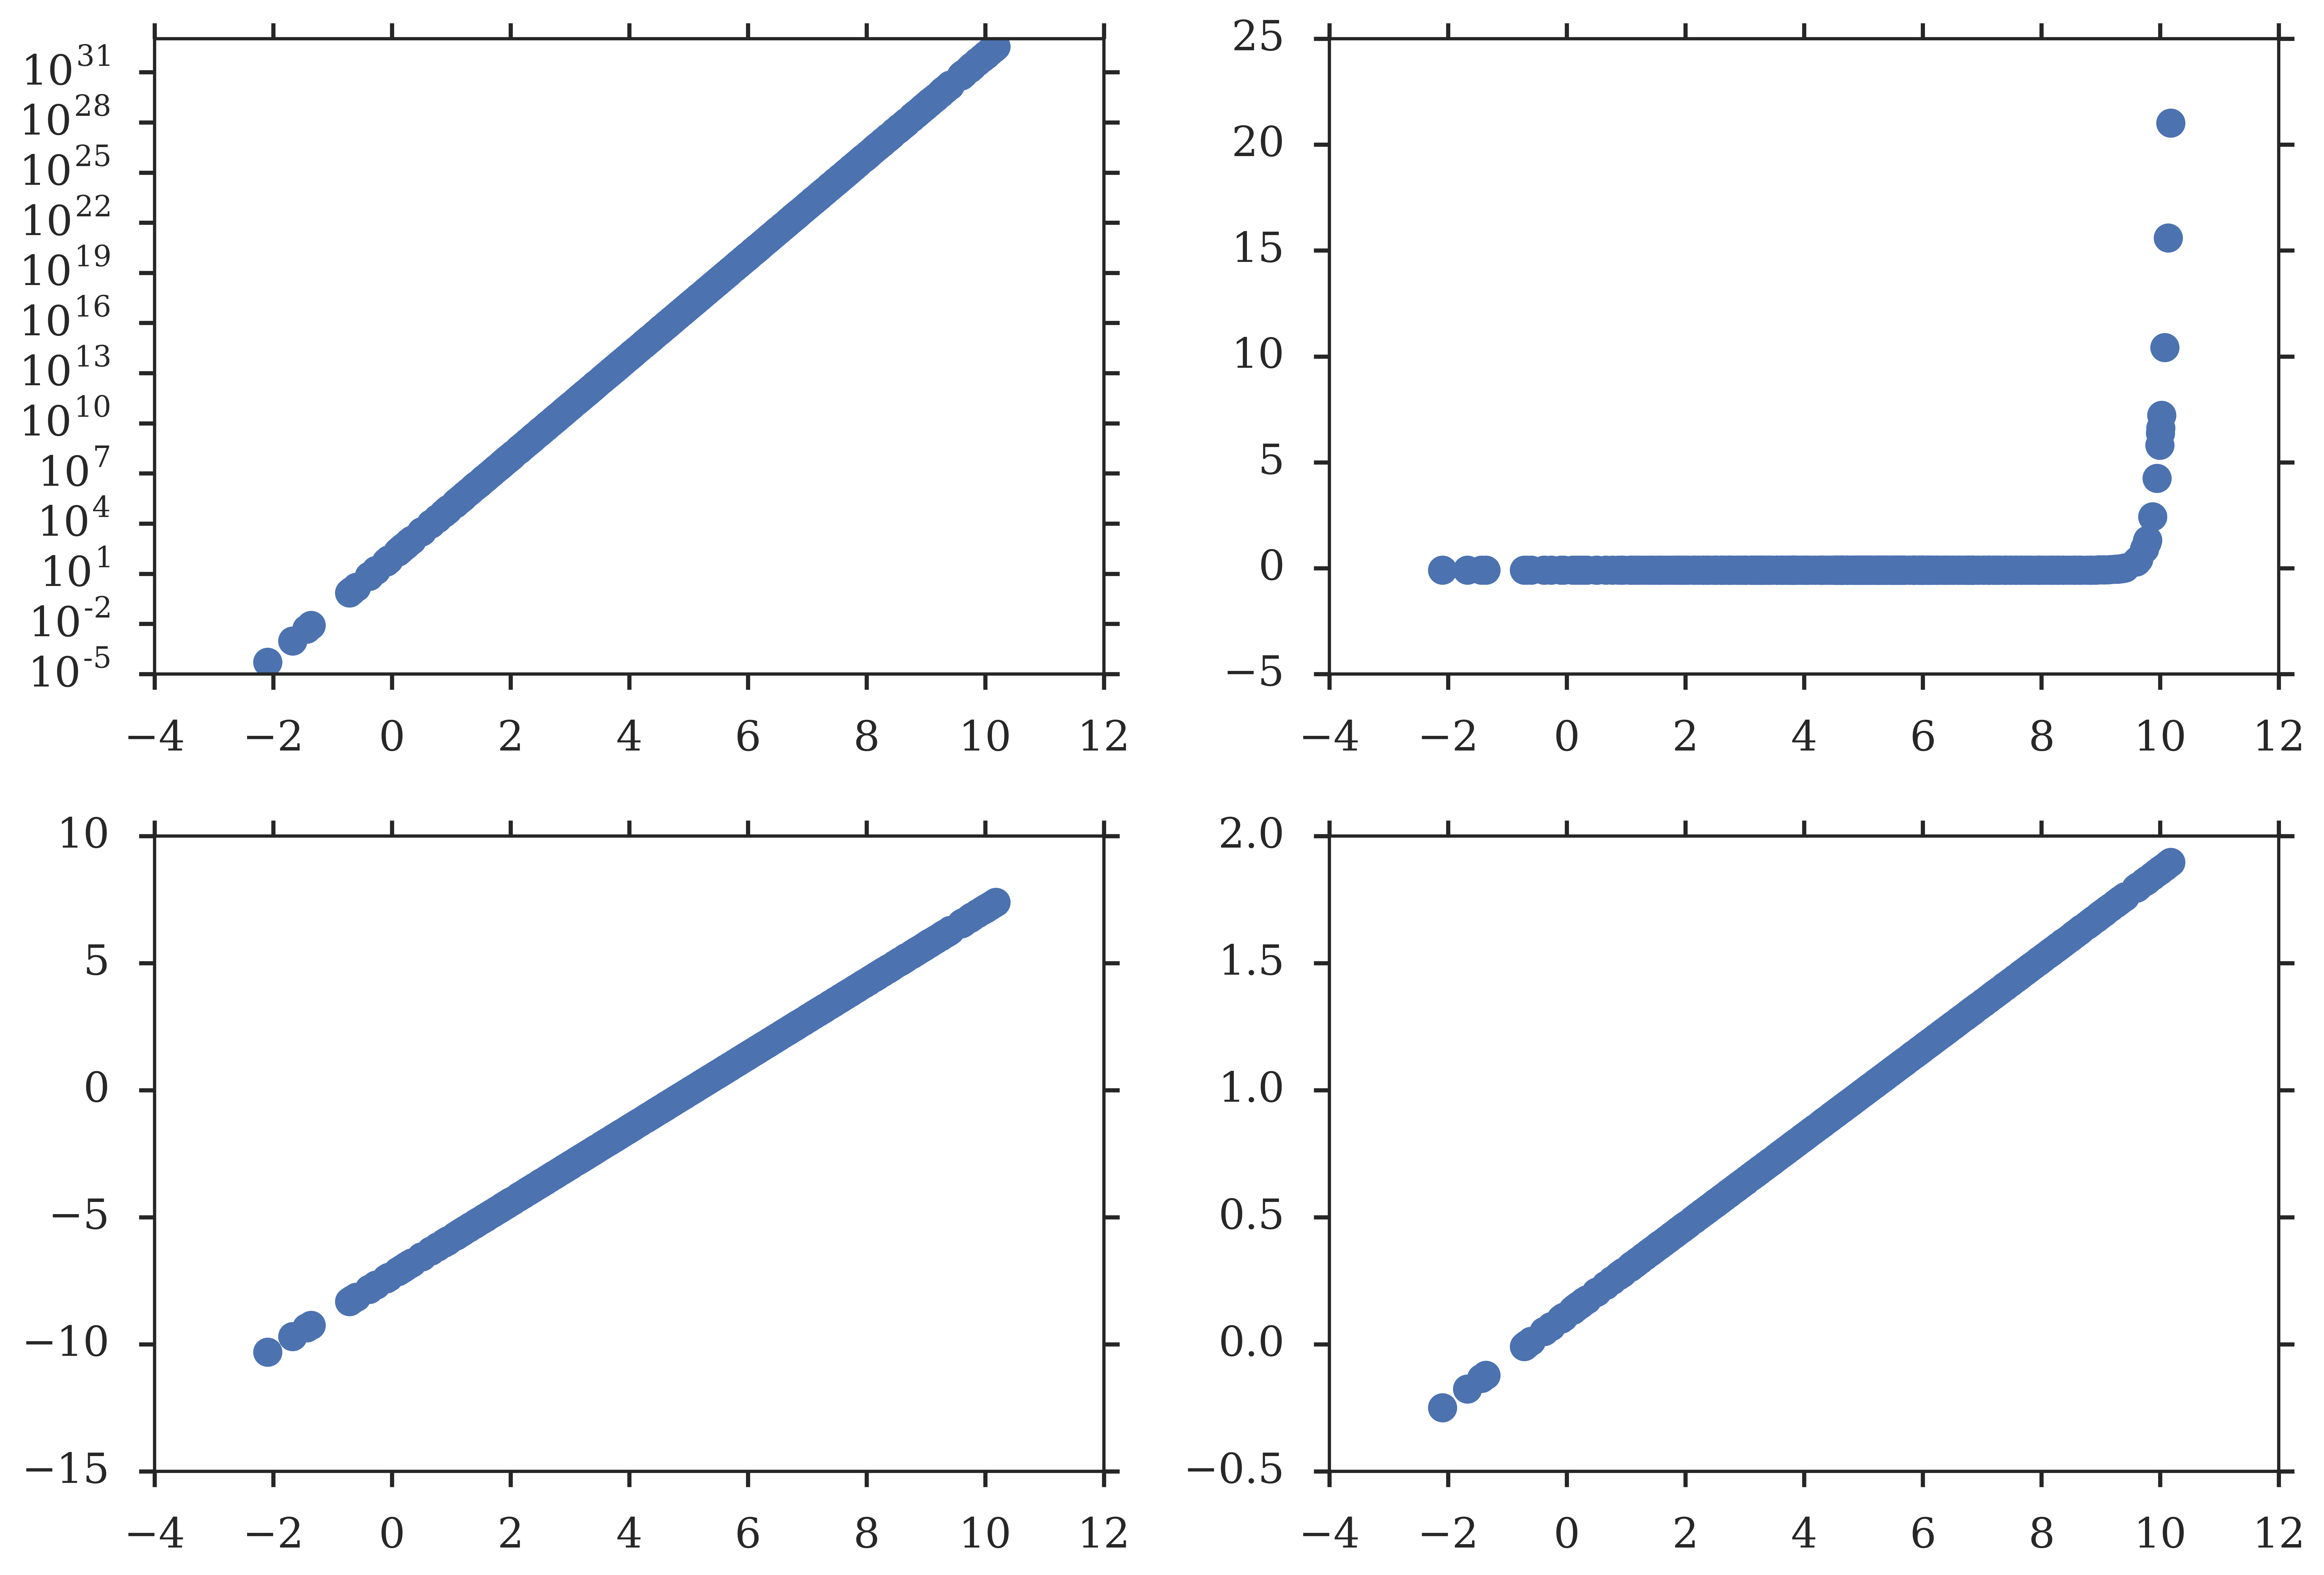

In [356]:
plt.close("all")
plt.clf()
with sns.plotting_context("poster"):
    fig, ax = plt.subplots(2,2)
    ax[0,0].plot(x,y, marker="o", linestyle="None")
    ax[0,0].set_yscale("log")
    z = (y - y.mean()) / y.std()
    ax[0,1].plot(x,z, marker="o", linestyle="None")
    #ax[1].set_yscale("log")
    z = np.log10(y)
    z = (z - z.mean()) / x.std()
    ax[1,0].plot(x,z, marker="o", linestyle="None")
    z = np.log10(y)
    z = (z/z.mean())
    ax[1,1].plot(x,z, marker="o", linestyle="None")
    fig.tight_layout()